#### **Find the emission pathways that caused the change in air quality over 2015-2017 in China**
- Per gridcell (emulator).  
- Remove the inputs that don't predict the correct change.  

##### **Steps**

*Calculated on HPC using `find_emissions_that_caused_air_quality_change.py` and `find_emissions_that_caused_air_quality_change.bash`.*

1. Load observations for 1 station.  
2. Find the change in measured PM2.5 (annual-mean) and O3 (6mDM8h) concentrations for this location over 2015-2017.  
3. Filter through predictions of all emission configurations for this location. 
4. Keep emission configurations where the prediction matchs (within 1%) the measured change in PM2.5/O3 concentrations.  

*Calculated in this notebook.*

5. Split by region.  
6. Compare to bottom-up estimates.  

In [2]:
import glob
import tabula
import joblib
from itertools import islice
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import re
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

### Bottom-up emissions

In [3]:
### bottom up emissions 2015-2017 - Zheng et al., 2018 ACP
df = tabula.read_pdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/zheng2018.pdf', pages=7)
df.drop(columns=['Unnamed: 2', 'Unnamed: 4', 'Unnamed: 9', 'c'], inplace=True)
df.columns = ['sector', 'so2', 'nox', 'nmvoc', 'nh3', 'co', 'tsp', 'pm10', 'pm25', 'bc', 'oc', 'co2']

df_2010 = df.iloc[0:7].copy()
df_2011 = df.iloc[7:14].copy()
df_2012 = df.iloc[14:21].copy()
df_2013 = df.iloc[21:28].copy()
df_2014 = df.iloc[28:35].copy()
df_2015 = df.iloc[35:42].copy()
df_2016 = df.iloc[42:49].copy()
df_2017 = df.iloc[49:56].copy()

df_2010.set_index('sector', inplace=True)
df_2011.set_index('sector', inplace=True)
df_2012.set_index('sector', inplace=True)
df_2013.set_index('sector', inplace=True)
df_2014.set_index('sector', inplace=True)
df_2015.set_index('sector', inplace=True)
df_2016.set_index('sector', inplace=True)
df_2017.set_index('sector', inplace=True)

df_2010 = df_2010.astype('float32').copy()
df_2011 = df_2011.astype('float32').copy()
df_2012 = df_2012.astype('float32').copy()
df_2013 = df_2013.astype('float32').copy()
df_2014 = df_2014.astype('float32').copy()
df_2015 = df_2015.astype('float32').copy()
df_2016 = df_2016.astype('float32').copy()
df_2017 = df_2017.astype('float32').copy()

df_diff = ((100 * df_2017 / df_2015) - 100).copy()
df_diff.drop(['2015', '2017'], inplace=True)
df_diff

,so2,nox,nmvoc,nh3,co,tsp,pm10,pm25,bc,oc,co2
sector,,,,,,,,,,,
Agriculture,NaN,NaN,NaN,-1.030922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industry,-38.775513,-5.154640,3.191490,-25.000000,-12.455521,-29.299362,-22.388054,-20.454544,-25.000000,-25.0,-5.302750
Power,-53.846153,-17.647064,0.000000,NaN,6.666672,0.000000,0.000000,0.000000,NaN,NaN,9.054749
Residential,-17.241379,-11.111107,-14.285713,-25.000000,-10.937500,-15.909096,-17.073166,-16.666664,-14.285706,-15.0,3.837296
Solvent use,NaN,NaN,9.473686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transportation,0.000000,-3.750000,-11.111107,NaN,-12.802765,20.000008,20.000008,0.000000,0.000000,0.0,5.469841


In [ ]:
df_diff_2017vs2015 = ((100 * df_2017 / df_2015) - 100).copy()
df_diff_2017vs2015.drop(['2015', '2017'], inplace=True)
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff_2017vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff_2017vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff_2017vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff_2017vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff_2017vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2017 vs 2015')
print(f'RES{zhang2018_bottomup20152017_allspecies_res:.2f}_IND{zhang2018_bottomup20152017_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152017_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152017_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152017_allspecies_ene:.2f}')
print()

In [ ]:
df_diff_2017vs2015 = ((100 * df_2017 / df_2015) - 100).copy()
df_diff_2017vs2015.drop(['2015', '2017'], inplace=True)
species = ['nox', 'nmvoc', 'nh3', 'pm25']
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff_2017vs2015.loc['Residential'][species].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff_2017vs2015.loc['Industry'][species].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff_2017vs2015.loc['Transportation'][species].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff_2017vs2015.loc['Agriculture'][species].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff_2017vs2015.loc['Power'][species].mean() / 100)
print('2017 vs 2015')
print(f'RES{zhang2018_bottomup20152017_allspecies_res:.2f}_IND{zhang2018_bottomup20152017_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152017_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152017_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152017_allspecies_ene:.2f}')
print()

In [ ]:
df_diff_2010vs2015 = ((100 * df_2010 / df_2015) - 100).copy()
df_diff_2010vs2015.drop(['2015', '2010'], inplace=True)
zhang2018_bottomup20152010_allspecies_res = 1 + (df_diff_2010vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_ind = 1 + (df_diff_2010vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_tra = 1 + (df_diff_2010vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_agr = 1 + (df_diff_2010vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_ene = 1 + (df_diff_2010vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2010 vs 2015')
print(f'RES{zhang2018_bottomup20152010_allspecies_res:.2f}_IND{zhang2018_bottomup20152010_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152010_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152010_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152010_allspecies_ene:.2f}')
print()

df_diff_2011vs2015 = ((100 * df_2011 / df_2015) - 100).copy()
df_diff_2011vs2015.drop(['2015', '2011'], inplace=True)
zhang2018_bottomup20152011_allspecies_res = 1 + (df_diff_2011vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_ind = 1 + (df_diff_2011vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_tra = 1 + (df_diff_2011vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_agr = 1 + (df_diff_2011vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_ene = 1 + (df_diff_2011vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2011 vs 2015')
print(f'RES{zhang2018_bottomup20152011_allspecies_res:.2f}_IND{zhang2018_bottomup20152011_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152011_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152011_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152011_allspecies_ene:.2f}')
print()

df_diff_2012vs2015 = ((100 * df_2012 / df_2015) - 100).copy()
df_diff_2012vs2015.drop(['2015', '2012'], inplace=True)
zhang2018_bottomup20152012_allspecies_res = 1 + (df_diff_2012vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_ind = 1 + (df_diff_2012vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_tra = 1 + (df_diff_2012vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_agr = 1 + (df_diff_2012vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_ene = 1 + (df_diff_2012vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2012 vs 2015')
print(f'RES{zhang2018_bottomup20152012_allspecies_res:.2f}_IND{zhang2018_bottomup20152012_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152012_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152012_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152012_allspecies_ene:.2f}')
print()

df_diff_2013vs2015 = ((100 * df_2013 / df_2015) - 100).copy()
df_diff_2013vs2015.drop(['2015', '2013'], inplace=True)
zhang2018_bottomup20152013_allspecies_res = 1 + (df_diff_2013vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_ind = 1 + (df_diff_2013vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_tra = 1 + (df_diff_2013vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_agr = 1 + (df_diff_2013vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_ene = 1 + (df_diff_2013vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2013 vs 2015')
print(f'RES{zhang2018_bottomup20152013_allspecies_res:.2f}_IND{zhang2018_bottomup20152013_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152013_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152013_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152013_allspecies_ene:.2f}')
print()

df_diff_2014vs2015 = ((100 * df_2014 / df_2015) - 100).copy()
df_diff_2014vs2015.drop(['2015', '2014'], inplace=True)
zhang2018_bottomup20152014_allspecies_res = 1 + (df_diff_2014vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_ind = 1 + (df_diff_2014vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_tra = 1 + (df_diff_2014vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_agr = 1 + (df_diff_2014vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_ene = 1 + (df_diff_2014vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2014 vs 2015')
print(f'RES{zhang2018_bottomup20152014_allspecies_res:.2f}_IND{zhang2018_bottomup20152014_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152014_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152014_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152014_allspecies_ene:.2f}')
print()

df_diff_2016vs2015 = ((100 * df_2016 / df_2015) - 100).copy()
df_diff_2016vs2015.drop(['2015', '2016'], inplace=True)
zhang2018_bottomup20152016_allspecies_res = 1 + (df_diff_2016vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_ind = 1 + (df_diff_2016vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_tra = 1 + (df_diff_2016vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_agr = 1 + (df_diff_2016vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_ene = 1 + (df_diff_2016vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2016 vs 2015')
print(f'RES{zhang2018_bottomup20152016_allspecies_res:.2f}_IND{zhang2018_bottomup20152016_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152016_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152016_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152016_allspecies_ene:.2f}')
print()

df_diff_2017vs2015 = ((100 * df_2017 / df_2015) - 100).copy()
df_diff_2017vs2015.drop(['2015', '2017'], inplace=True)
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff_2017vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff_2017vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff_2017vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff_2017vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff_2017vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2017 vs 2015')
print(f'RES{zhang2018_bottomup20152017_allspecies_res:.2f}_IND{zhang2018_bottomup20152017_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152017_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152017_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152017_allspecies_ene:.2f}')
print()

### Original matching - Done on ARC4

In [3]:
obs_files = glob.glob('/nfs/a68/earlacoa/china_measurements_corrected_uptofeb2021/*.nc')

df_obs = pd.read_csv(
    '/nfs/a68/earlacoa/china_measurements_corrected_uptofeb2021/df_obs_o3_6mDM8h_ppb_PM2_5_DRY.csv',
    index_col='datetime',
    parse_dates=True
)
df_obs

,station_id,station_lat,station_lon,name,prefecture,o3_6mDM8h_ppb,PM2_5_DRY
datetime,,,,,,,
2015-01-01,2653A,37.93580,102.6469,Leitai,"Wuwei, Gansu",38.148376,34.739528
2015-01-01,2232A,41.94190,126.4078,Environmental Protection Agency,Baishan,43.855760,46.969628
2015-01-01,1843A,30.78190,111.3296,Yiling District,Yichang,21.898740,63.536287
2015-01-01,1093A,40.81440,111.6080,Sugar factory,Hohhot,33.522636,36.022877
2015-01-01,1620A,34.98170,118.2764,Xinguang Woolen Mill,Linyi,60.683464,78.032293
...,...,...,...,...,...,...,...
2020-01-01,1019A,39.21330,117.1837,Beichen Science and Technology Park,Tianjin,66.804878,49.720678
2020-01-01,1329A,30.61030,114.4272,Qingshan Steel Flower,Wuhan,53.300035,45.750527
2020-01-01,1077A,37.09670,114.4821,Dahuoquan,Xingtai,67.773175,56.468144


In [ ]:
outputs = ['o3_6mDM8h_ppb', 'PM2_5_DRY']

path_predictions = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions'

matrix_stacked = np.array(np.meshgrid(
    np.linspace(0.3, 1.3, 6), # np.linspace(0.2, 1.3, 12) for 10% intervals
    np.linspace(0.3, 1.3, 6), # np.linspace(0.3, 1.3, 6) for 20% intervals
    np.linspace(0.3, 1.3, 6), # removing edges of parameter space 0.0, 0.1, 1.4, 1.5
    np.linspace(0.3, 1.3, 6),
    np.linspace(0.3, 1.3, 6)
)).T.reshape(-1, 5)

obs_change_abs = {}
obs_change_per = {}
baselines = {}
targets = {}
station_diffs_abs = {}
station_diffs_per = {}

In [ ]:
for output in outputs:
    for obs_file in obs_files:
        station_id = obs_file[47:-3]
        lat = df_obs.loc[df_obs.station_id == station_id].station_lat.unique()[0]
        lon = df_obs.loc[df_obs.station_id == station_id].station_lon.unique()[0]
        
        change_per = 100 * ((df_obs.loc[df_obs.station_id == station_id][output]['2017'].values[0] / \
                             df_obs.loc[df_obs.station_id == station_id][output]['2015'].values[0]) - 1)
        change_abs = df_obs.loc[df_obs.station_id == station_id][output]['2017'].values[0] - \
                     df_obs.loc[df_obs.station_id == station_id][output]['2015'].values[0]

        obs_change_abs.update({f'{station_id}_{output}': change_abs})
        obs_change_per.update({f'{station_id}_{output}': change_per})

        if output == 'o3_6mDM8h_ppb':
            emulator_output = 'o3_6mDM8h'
        else:
            emulator_output = output
            
        with xr.open_dataset(
            f'{path_predictions}/{emulator_output}/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{emulator_output}_popgrid_0.25deg.nc'
        )[emulator_output] as ds:
            baseline = ds.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest').values
                    
        baselines.update({f'{station_id}_{output}': baseline})

        target_abs = baseline + change_abs
        target_per = baseline * (1 + (change_per / 100))
        target = np.mean([target_abs, target_per])
        targets.update({f'{station_id}_{output}': target})
        
        target_diffs_abs = {}
        target_diffs_per = {}
        
        for matrix in matrix_stacked:
            inputs = matrix.reshape(-1, 5)        
            filename = f'RES{inputs[0][0]:.1f}_IND{inputs[0][1]:.1f}_TRA{inputs[0][2]:.1f}_AGR{inputs[0][3]:.1f}_ENE{inputs[0][4]:.1f}'
            with xr.open_dataset(
                f'{path_predictions}/{emulator_output}/ds_{filename}_{emulator_output}_popgrid_0.25deg.nc'
            )[emulator_output] as ds:
                prediction = ds.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest').values

            target_diff_abs = targets[f'{station_id}_{output}'] - prediction
            target_diff_per = (100 * (prediction / targets[f'{station_id}_{output}'])) - 100
            
            if abs(target_diff_per) < 1: # +/- 1% of target
                target_diffs_abs.update({filename: target_diff_abs})
                target_diffs_per.update({filename: target_diff_per})

        station_diffs_abs.update({f'{station_id}_{output}': target_diffs_abs})
        station_diffs_per.update({f'{station_id}_{output}': target_diffs_per})

In [ ]:
# for key in [key for key in targets.keys()]:
#     if np.isnan(targets[key]):
#         del targets[key]

In [ ]:
target_diffs = {}
for key in [key for key in targets.keys()]:
    target_diffs.update({key: targets[key] - baselines[key]})

In [ ]:
# for key in list(set([key for key in emulators.keys()]) - set([key for key in targets.keys()])):
#     del emulators[key]

In [ ]:
keys = [list(station_diffs_per[station].keys())for station in station_diffs_per.keys()]
keys_flatten = [item for sublist in keys for item in sublist]
keys_unique = {}
for key in keys_flatten:
    if key not in keys_unique:
        keys_unique.update({key: 1})
    elif key in keys_unique:
        keys_unique.update({key: keys_unique[key] + 1})

In [ ]:
path = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2017_20percentintervals'

joblib.dump(targets, f'{path}/targets.joblib')
joblib.dump(baselines, f'{path}/baselines.joblib')
joblib.dump(target_diffs, f'{path}/target_diffs.joblib')
joblib.dump(obs_change_abs, f'{path}/obs_change_abs.joblib')
joblib.dump(obs_change_per, f'{path}/obs_change_per.joblib')
joblib.dump(keys_unique, f'{path}/keys_unique.joblib')
joblib.dump(station_diffs_per, f'{path}/station_diffs_per_1percent.joblib')
joblib.dump(station_diffs_abs, f'{path}/station_diffs_abs_1percent.joblib')

### Combine ARC4 emission matching for all stations

In [9]:
for years in ['2015-2016', '2015-2017', '2015-2018', '2015-2019', '2015-2020']: 
    print(years)
    path = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/{years}_20percentintervals_adjusted_scaled'
    
    files_targets = sorted(glob.glob(f'{path}/targets*.joblib'))
    files_baselines = sorted(glob.glob(f'{path}/baselines*.joblib'))
    files_target_diffs = sorted(glob.glob(f'{path}/target_diffs*.joblib'))
    files_station_diffs_per = sorted(glob.glob(f'{path}/station_diffs_per*.joblib'))
    files_station_diffs_abs = sorted(glob.glob(f'{path}/station_diffs_abs*.joblib'))
    
    targets = {}
    baselines = {}
    target_diffs = {}
    station_diffs_per = {}
    station_diffs_abs = {}

    for index in range(len(files_targets)):
        if 'PM2_5_DRY' in files_target_diffs[index]:
            output = 'PM2_5_DRY'
        elif 'o3_6mDM8h' in files_target_diffs[index]:
            output = 'o3_6mDM8h'

        station_id = files_target_diffs[index][-12:-7]

        target = joblib.load(files_targets[index])
        baseline = joblib.load(files_baselines[index])
        target_diff = joblib.load(files_target_diffs[index])
        station_diff_per = joblib.load(files_station_diffs_per[index])
        station_diff_abs = joblib.load(files_station_diffs_abs[index])

        targets.update({f'{station_id}_{output}': target[[key for key in target.keys()][0]]})
        baselines.update({f'{station_id}_{output}': baseline[[key for key in baseline.keys()][0]]})
        target_diffs.update({f'{station_id}_{output}': target_diff[[key for key in target_diff.keys()][0]]})
        station_diffs_per.update({f'{station_id}_{output}': station_diff_per[[key for key in station_diff_per.keys()][0]]})
        station_diffs_abs.update({f'{station_id}_{output}': station_diff_abs[[key for key in station_diff_abs.keys()][0]]})
        
    joblib.dump(targets, f'{path}/targets_adjusted_scaled.joblib')
    joblib.dump(baselines, f'{path}/baselines_adjusted_scaled.joblib')
    joblib.dump(target_diffs, f'{path}/target_diffs_adjusted_scaled.joblib')
    joblib.dump(station_diffs_per, f'{path}/station_diffs_per_adjusted_scaled.joblib')
    joblib.dump(station_diffs_abs, f'{path}/station_diffs_abs_adjusted_scaled.joblib')

2015-2017
2015-2018
2015-2019
2015-2020


### Find most common emission trends per region

In [11]:
regional_provinces = {
    'Beijing': 'North China',
    'Tianjin': 'North China',
    'Hebei': 'North China',
    'Shanxi': 'North China',
    'Nei Mongol': 'North China',
    'Liaoning': 'North East China',
    'Jilin': 'North East China',
    'Heilongjiang': 'North East China',
    'Shanghai': 'East China',
    'Jiangsu': 'East China',
    'Zhejiang': 'East China', 
    'Anhui': 'East China', 
    'Fujian': 'East China', 
    'Jiangxi': 'East China', 
    'Shandong': 'East China',
    'Taiwan': 'East China',
    'Henan': 'South Central China',
    'Hubei': 'South Central China',
    'Hunan': 'South Central China',
    'Guangdong': 'South Central China',
    'Guangxi': 'South Central China',
    'Hainan': 'South Central China',
    'Hong Kong': 'South Central China',
    'Macao': 'South Central China',
    'Chongqing': 'South West China',
    'Sichuan': 'South West China',
    'Guizhou': 'South West China',
    'Yunnan': 'South West China',
    'Xizang': 'South West China',
    'Shaanxi': 'North West China',
    'Gansu': 'North West China', 
    'Qinghai': 'North West China',
    'Ningxia Hui': 'North West China',
    'Xinjiang Uygur': 'North West China'
}

gba_prefectures = ['Dongguan', 'Foshan', 'Guangzhou', 'Huizhou', 'Jiangmen', 'Shenzhen', 'Zhaoqing', 'Zhongshan', 'Zhuhai', 'Hong Kong', 'Macao']

In [12]:
gdf_prefectures_china = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_3.shp')
gdf_prefectures_hongkong = gpd.read_file('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_1.shp')
gdf_prefectures_macao = gpd.read_file('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_2.shp')

list_prefectures_gba = []
for gba_prefecture in gba_prefectures:
    list_prefectures_gba.append(gdf_prefectures_china.loc[gdf_prefectures_china.NAME_2 == gba_prefecture])


list_prefectures_gba.append(gdf_prefectures_hongkong)
list_prefectures_gba.append(gdf_prefectures_macao)
    
gdf_prefectures_gba = pd.concat(list_prefectures_gba)

In [13]:
prefectures = {
    'North China': [],
    'North East China': [],
    'East China': [],
    'South Central China': [],
    'South West China': [],
    'North West China': [],
}
for prefecture in gdf_prefectures_china.NAME_2.unique():
    province = gdf_prefectures_china.loc[gdf_prefectures_china.NAME_2 == prefecture].NAME_1.unique()[0]
    region = regional_provinces[province]
    prefectures[region].append(prefecture)
    

for region, prefecture_list in prefectures.items():
    prefecture_list = list(set(prefecture_list))
    prefectures.update({region: prefecture_list})

In [14]:
regional_prefectures = {}
for region, prefecture_list in prefectures.items():
    prefecture_list = list(set(prefecture_list))
    for prefecture in prefecture_list:
        regional_prefectures.update({prefecture: region})

In [15]:
gdf_china_north = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp')
gdf_china_north_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp')
gdf_china_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp')
gdf_china_south_central = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp')
gdf_china_south_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp')
gdf_china_north_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp')

In [16]:
from shapely.geometry import Point

In [17]:
obs_lats = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/obs_lats.joblib')
obs_lons = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/obs_lons.joblib')
obs_gba = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/obs_gba.joblib')
obs_regions = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/obs_regions.joblib')
obs_prefectures = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/obs_prefectures.joblib')

In [ ]:
# obs_lats = {}
# obs_lons = {}
# obs_prefectures = {}
# obs_regions = {}
# obs_gba = {}

# obs_files = glob.glob('/nfs/a68/earlacoa/china_measurements_corrected_uptofeb2021/*.nc')

# for obs_file in obs_files:
#     with xr.open_dataset(obs_file) as ds:
#         station_id = ds.station
#         if '.nc' in station_id:
#             station_id = station_id[:-3]
            
#         obs_lats.update({station_id: ds.lat})
#         obs_lons.update({station_id: ds.lon})
#         obs_prefectures.update({station_id: ds.city})
        
#         if gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north).values[0]:
#             region = 'North China'
#         elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north_east).values[0]:
#             region = 'North East China'
#         elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_east).values[0]:
#             region = 'East China'
#         elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_south_central).values[0]:
#             region = 'South Central China'
#         elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_south_west).values[0]:
#             region = 'South West China'
#         elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north_west).values[0]:
#             region = 'North West China'
            
#         obs_regions.update({station_id: region})
#         if (ds.city in gba_prefectures) or (ds.city == 'Hong Kong') or (ds.city == 'Macao'):
#             obs_gba.update({station_id: True})
#         else:
#             obs_gba.update({station_id: False})

In [ ]:
# obs_lats = {}
# obs_lons = {}
# obs_prefectures = {}
# obs_regions = {}
# obs_gba = {}
  
# for obs_file in obs_files:
#     with xr.open_dataset(obs_file) as ds:
#         station_id = ds.station
#         if '.nc' in station_id:
#             station_id = station_id[:-3]
            
#         obs_lats.update({station_id: ds.lat})
#         obs_lons.update({station_id: ds.lon})
#         obs_prefectures.update({station_id: ds.city})
#         if ds.city == 'Lhasa Googut':
#             region = regional_prefectures['Lhasa']
#         elif ds.city == 'Huaian':
#             region = regional_prefectures["Huai'an"]
#         elif ds.city == 'Urumqi':
#             region = 'North West China'
#         elif ds.city == 'Ordos City':
#             region = regional_prefectures["Ordos"]
#         elif ds.city == 'Yingkou':
#             region = 'North East China'
#         elif ds.city == 'Sunlight':
#             region = 'East China'
#         elif ds.city == 'Iris':
#             region = 'South Central China'
#         elif ds.city == 'chicken':
#             region = 'South Central China'
#         elif ds.city == 'Mudan River':
#             region = 'North West China'
#         elif ds.city == 'Maanshan':
#             region = 'East China'
#         elif ds.city == 'North Sea':
#             region = 'South Central China'
#         elif ds.city == 'Yanan':
#             region = 'North China'
#         elif ds.city == 'Korla':
#             region = 'North West China'
#         elif ds.city == 'Shouguang':
#             region = 'East China'
#         elif ds.city == 'Zhang Qiu':
#             region = 'East China'
#         elif ds.city == 'Jimo':
#             region = 'East China'
#         elif ds.city == 'Jiaonan':
#             region = 'East China'
#         elif ds.city == 'Jiaozhou':
#             region = 'East China'
#         elif ds.city == 'Laixi':
#             region = 'East China'
#         elif ds.city == 'Pingdu':
#             region = 'East China'
#         elif ds.city == 'Penglai':
#             region = 'East China'
#         else:
#             region = regional_prefectures[ds.city]
            
#         obs_regions.update({station_id: region})
#         if (ds.city in gba_prefectures) or (ds.city == 'Hong Kong') or (ds.city == 'Macao'):
#             obs_gba.update({station_id: True})
#         else:
#             obs_gba.update({station_id: False})

In [18]:
regions = ['China', 'GBA', 'North China', 'North East China', 'East China', 'South Central China', 'South West China', 'North West China']
region_stations = {key: [] for key in regions}

for station_id, station_region in obs_regions.items():
    region_stations['China'].append(station_id)
    region_stations[station_region].append(station_id)
    
    if obs_gba[station_id] == True:
        region_stations['GBA'].append(station_id)

In [19]:
for years in ['2015-2016', '2015-2017', '2015-2018', '2015-2019', '2015-2020']: 
    print(years)
    path = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/{years}_20percentintervals_adjusted_scaled'

    targets = joblib.load(f'{path}/targets_adjusted_scaled.joblib')
    baselines = joblib.load(f'{path}/baselines_adjusted_scaled.joblib')
    target_diffs = joblib.load(f'{path}/target_diffs_adjusted_scaled.joblib')
    station_diffs_per = joblib.load(f'{path}/station_diffs_per_adjusted_scaled.joblib')
    station_diffs_abs = joblib.load(f'{path}/station_diffs_abs_adjusted_scaled.joblib')
    
    regional_targets = {}
    regional_baselines = {}
    regional_target_diffs = {}
    regional_station_diffs_per = {}
    regional_station_diffs_abs = {}

    for region in regions:
        regional_targets.update({region: dict((key, value) for key, value in targets.items() if key[0:5] in region_stations[region])})
        regional_baselines.update({region: dict((key, value) for key, value in baselines.items() if key[0:5] in region_stations[region])})
        regional_target_diffs.update({region: dict((key, value) for key, value in target_diffs.items() if key[0:5] in region_stations[region])})
        regional_station_diffs_per.update({region: dict((key, value) for key, value in station_diffs_per.items() if key[0:5] in region_stations[region])})
        regional_station_diffs_abs.update({region: dict((key, value) for key, value in station_diffs_abs.items() if key[0:5] in region_stations[region])})
        
    outputs = ['PM2_5_DRY', 'o3_6mDM8h', 'either']

    regional_keys_unique_sorted = {}
    regional_target_diffs_under0p5 = {}

    for output in outputs:
        for region in regions:
            if output == 'either':
                keys = [list(regional_station_diffs_per[region][stationid_output].keys()) for stationid_output in regional_station_diffs_per[region].keys()]
            elif output in ['PM2_5_DRY', 'o3_6mDM8h']:
                keys = [list(regional_station_diffs_per[region][stationid_output].keys()) for stationid_output in regional_station_diffs_per[region].keys() if output in stationid_output]

            keys_flatten = [item for sublist in keys for item in sublist]

            keys_unique = {}
            for key in keys_flatten:
                if key not in keys_unique:
                    keys_unique.update({key: 1})
                elif key in keys_unique:
                    keys_unique.update({key: keys_unique[key] + 1})


            keys_unique_sorted = {key: value for key, value in sorted(keys_unique.items(), key=lambda item: item[1], reverse=True)}
            regional_keys_unique_sorted.update({f'{region}_{output}': keys_unique_sorted})

            target_diffs_under0p5 = {}
            for key, value in regional_target_diffs[region].items():
                if abs(value) < 0.5:
                    target_diffs_under0p5.update({key: value})


            regional_target_diffs_under0p5.update({f'{region}_{output}': target_diffs_under0p5})
            
    # keys have to match *per station* for both pm25 and o3
    # then add the interaction of these sets to the dictionaries

    output = 'both'

    for region in regions:
        stationids_PM2_5_DRY = [stationid_output for stationid_output in regional_station_diffs_per[region].keys() if 'PM2_5_DRY' in stationid_output]
        stationids_o3_6mDM8h = [stationid_output for stationid_output in regional_station_diffs_per[region].keys() if 'o3_6mDM8h' in stationid_output]

        keys_unique = {}

        for index in range(len(stationids_PM2_5_DRY)):
            stationid_PM2_5_DRY = stationids_PM2_5_DRY[index]
            stationid_o3_6mDM8h = stationids_o3_6mDM8h[index]
            if stationid_PM2_5_DRY.split('_')[0] == stationid_o3_6mDM8h.split('_')[0]:
                stationid = stationid_o3_6mDM8h.split('_')[0]

            station_keys_PM2_5_DRY = set(list(regional_station_diffs_per[region][stationid_PM2_5_DRY].keys()))
            station_keys_o3_6mDM8h = set(list(regional_station_diffs_per[region][stationid_o3_6mDM8h].keys()))

            station_keys_both = set.intersection(station_keys_PM2_5_DRY, station_keys_o3_6mDM8h)

            for key in station_keys_both:
                if key not in keys_unique:
                    keys_unique.update({key: 1})
                elif key in keys_unique:
                    keys_unique.update({key: keys_unique[key] + 1})

        keys_unique_sorted = {key: value for key, value in sorted(keys_unique.items(), key=lambda item: item[1], reverse=True)}
        regional_keys_unique_sorted.update({f'{region}_{output}': keys_unique_sorted})

        target_diffs_under0p5 = {}
        for key, value in regional_target_diffs[region].items():
            if abs(value) < 0.5:
                target_diffs_under0p5.update({key: value})


        regional_target_diffs_under0p5.update({f'{region}_{output}': target_diffs_under0p5})
        
    joblib.dump(obs_lats, f'{path}/obs_lats.joblib')
    joblib.dump(obs_lons, f'{path}/obs_lons.joblib')
    joblib.dump(obs_prefectures, f'{path}/obs_prefectures.joblib')
    joblib.dump(obs_regions, f'{path}/obs_regions.joblib')
    joblib.dump(obs_gba, f'{path}/obs_gba.joblib')

    joblib.dump(regional_targets, f'{path}/regional_targets.joblib')
    joblib.dump(regional_baselines, f'{path}/regional_baselines.joblib')
    joblib.dump(regional_target_diffs, f'{path}/regional_target_diffs.joblib')
    joblib.dump(regional_station_diffs_per, f'{path}/regional_station_diffs_per.joblib')
    joblib.dump(regional_station_diffs_abs, f'{path}/regional_station_diffs_abs.joblib')

    joblib.dump(regional_keys_unique_sorted, f'{path}/regional_keys_unique_sorted.joblib')
    joblib.dump(regional_target_diffs_under0p5, f'{path}/regional_target_diffs_under0p5.joblib')

2015-2016
2015-2017
2015-2018
2015-2019
2015-2020


### Dataframe

In [21]:
for years in ['2015-2016', '2015-2017', '2015-2018', '2015-2019', '2015-2020']: 
    print(years)
    path = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/{years}_20percentintervals_adjusted_scaled'
    
    regional_targets = joblib.load(f'{path}/regional_targets.joblib')
    regional_keys_unique_sorted = joblib.load(f'{path}/regional_keys_unique_sorted.joblib')
    regional_target_diffs_under0p5 = joblib.load(f'{path}/regional_target_diffs_under0p5.joblib')
    
    number_of_stations = {}
    number_of_emission_configurations = {}
    first_emission_configuration_keys = {}
    second_emission_configuration_keys = {}
    third_emission_configuration_keys = {}
    first_emission_configuration_values = {}
    second_emission_configuration_values = {}
    third_emission_configuration_values = {}
    number_of_stations_with_target_diff_under_0p5 = {}

    for output in ['PM2_5_DRY']:#, 'o3_6mDM8h', 'either', 'both']:
        for region in regional_targets.keys():
            number_of_stations.update({f'{region}_{output}': len(regional_targets[region].keys())})
            number_of_emission_configurations.update({f'{region}_{output}': len(regional_keys_unique_sorted[f'{region}_{output}'].keys())})

            top3_emission_configurations = list(islice(regional_keys_unique_sorted[f'{region}_{output}'].items(), 3))
            if top3_emission_configurations:
                first_emission_configuration_keys.update({f'{region}_{output}': top3_emission_configurations[0][0]})
                second_emission_configuration_keys.update({f'{region}_{output}': top3_emission_configurations[1][0]})
                third_emission_configuration_keys.update({f'{region}_{output}': top3_emission_configurations[2][0]})
                first_emission_configuration_values.update({f'{region}_{output}': top3_emission_configurations[0][1]})
                second_emission_configuration_values.update({f'{region}_{output}': top3_emission_configurations[1][1]})
                third_emission_configuration_values.update({f'{region}_{output}': top3_emission_configurations[2][1]})
                number_of_stations_with_target_diff_under_0p5.update({f'{region}_{output}': len(regional_target_diffs_under0p5[f'{region}_{output}'])})
                
    
    print(len({key: value for key, value in regional_keys_unique_sorted[f'{region}_{output}'].items() if value > 10}))
    df_regions = pd.concat([
        pd.Series(number_of_stations, name='Stations'),
        pd.Series(number_of_emission_configurations, name='Possible Emission Configurations'),
        pd.Series(first_emission_configuration_keys, name='First Emission Configuration - Key'),
        pd.Series(first_emission_configuration_values, name='First Emission Configuration - Value'),
        pd.Series(second_emission_configuration_keys, name='Second Emission Configuration - Key'),
        pd.Series(second_emission_configuration_values, name='Second Emission Configuration - Value'),
        pd.Series(third_emission_configuration_keys, name='Third Emission Configuration - Key'),
        pd.Series(third_emission_configuration_values, name='Third Emission Configuration - Value'),
        pd.Series(number_of_stations_with_target_diff_under_0p5, name='Stations with trend size under 0.5 ugm-3')
    ], axis=1)
    #print(df_regions)
    #df_regions.to_csv(f'{path}/df_regions_adjusted_scaled.csv')
    #joblib.dump(regional_keys_unique_sorted, f'{path}/regional_keys_unique_sorted_adjusted_scaled.joblib')

2015-2016
963
2015-2017
26
2015-2018
148
2015-2019
104
2015-2020
185


### Plot

In [22]:
obs_files = glob.glob('/nfs/a68/earlacoa/china_measurements_corrected_uptofeb2021/*.nc')

df_obs = pd.read_csv(
    '/nfs/a68/earlacoa/china_measurements_corrected_uptofeb2021/df_obs_o3_6mDM8h_ppb_PM2_5_DRY.csv',
    index_col='datetime',
    parse_dates=True
)
df_obs.head()

,station_id,station_lat,station_lon,name,prefecture,o3_6mDM8h_ppb,PM2_5_DRY
datetime,,,,,,,
2015-01-01,2653A,37.9358,102.6469,Leitai,"Wuwei, Gansu",38.148376,34.739528
2015-01-01,2232A,41.9419,126.4078,Environmental Protection Agency,Baishan,43.855760,46.969628
2015-01-01,1843A,30.7819,111.3296,Yiling District,Yichang,21.898740,63.536287
2015-01-01,1093A,40.8144,111.6080,Sugar factory,Hohhot,33.522636,36.022877
2015-01-01,1620A,34.9817,118.2764,Xinguang Woolen Mill,Linyi,60.683464,78.032293


In [23]:
path_2016 = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2016_20percentintervals_adjusted_scaled'
path_2017 = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2017_20percentintervals_adjusted_scaled'
path_2018 = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2018_20percentintervals_adjusted_scaled'
path_2019 = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2019_20percentintervals_adjusted_scaled'
path_2020 = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2020_20percentintervals_adjusted_scaled'

df_regions_2016 = pd.read_csv(f'{path_2016}/df_regions_adjusted_scaled.csv')
df_regions_2017 = pd.read_csv(f'{path_2017}/df_regions_adjusted_scaled.csv')
df_regions_2018 = pd.read_csv(f'{path_2018}/df_regions_adjusted_scaled.csv')
df_regions_2019 = pd.read_csv(f'{path_2019}/df_regions_adjusted_scaled.csv')
df_regions_2020 = pd.read_csv(f'{path_2020}/df_regions_adjusted_scaled.csv')

regional_keys_unique_sorted_2016 = joblib.load(f'{path_2016}/regional_keys_unique_sorted_adjusted_scaled.joblib')
regional_keys_unique_sorted_2017 = joblib.load(f'{path_2017}/regional_keys_unique_sorted_adjusted_scaled.joblib')
regional_keys_unique_sorted_2018 = joblib.load(f'{path_2018}/regional_keys_unique_sorted_adjusted_scaled.joblib')
regional_keys_unique_sorted_2019 = joblib.load(f'{path_2019}/regional_keys_unique_sorted_adjusted_scaled.joblib')
regional_keys_unique_sorted_2020 = joblib.load(f'{path_2020}/regional_keys_unique_sorted_adjusted_scaled.joblib')

In [24]:
def make_boxplot(index, values, sector, bottomup):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    plt.ylim([0.0, 1.5])
    plt.yticks(np.arange(0, 1.75, 0.25))
    ax.set_yticklabels(np.arange(0, 175, 25))
    plt.yticks(fontsize=14)
    ax.axes.get_xaxis().set_visible(False)
    if index == 0:
        plt.ylabel('Percentage emissions ({\%})', fontsize=14)
    else:
        ax.axes.get_yaxis().set_visible(False)
        
    plt.title(sector)
    color1 = '#c7eae5'
    color2 = '#01665e'
    plt.boxplot(
        values, 
        patch_artist=True,
        boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
        capprops={'color': color2, 'linewidth': 1.5},
        whiskerprops={'color': color2, 'linewidth': 1.5},
        flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
        medianprops={'color': color2, 'linewidth': 1.5},
        showmeans=True,
        meanprops={'markeredgecolor': color2, 'color': color2},
        showfliers=False,
        whis=(5, 95),
        zorder=1
    )
    plt.scatter(1, bottomup, color='#8c510a', zorder=2, marker='*')
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')

In [25]:
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)

In [26]:
regions = {
    'North China': ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Nei Mongol'],
    'North East China': ['Liaoning', 'Jilin', 'Heilongjiang'],
    'East China': ['Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong'],
    'South Central China': ['Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan'],
    'South West China': ['Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang'],
    'North West China': ['Shaanxi', 'Gansu', 'Qinghai', 'Ningxia Hui', 'Xinjiang Uygur']
}
# GBA = Dongguan, Foshan, Guangzhou, Huizhou, Jiangmen, Shenzhen, Zhaoqing, Zhongshan, Zhuhai, Hong Kong, and Macao

regions_all = ['China', 'GBA'] + list(regions.keys())

In [233]:
# for i in range(2, max(regional_keys_unique_sorted_2020[f'{region}_{output}'].values()) + 2, 2):
#     print(i, ': ', len({key: value for key, value in regional_keys_unique_sorted_2020[f'{region}_{output}'].items() if value > i}))

In [40]:
#matching_method = 'both'
#matching_method = 'either'
#matching_method = 'PM2_5_DRY'
matching_method = 'o3_6mDM8h'

factors_all = {}

for region in regions_all:
    factors_res = {}
    factors_ind = {}
    factors_tra = {}
    factors_agr = {}
    factors_ene = {}
    for index, items in enumerate(list(itertools.islice(regional_keys_unique_sorted_2017[f'{region}_{matching_method}'].items(), 1000))):
        factor_res, factor_ind, factor_tra, factor_agr, factor_ene = [float(item) for item in re.findall('\d+\.\d+',  items[0])]
        factors_res.update({index: factor_res})
        factors_ind.update({index: factor_ind})
        factors_tra.update({index: factor_tra})
        factors_agr.update({index: factor_agr})
        factors_ene.update({index: factor_ene})
        
    factors_all.update({f'{region}_RES': factors_res})
    factors_all.update({f'{region}_IND': factors_ind})
    factors_all.update({f'{region}_TRA': factors_tra})
    factors_all.update({f'{region}_AGR': factors_agr})
    factors_all.update({f'{region}_ENE': factors_ene})

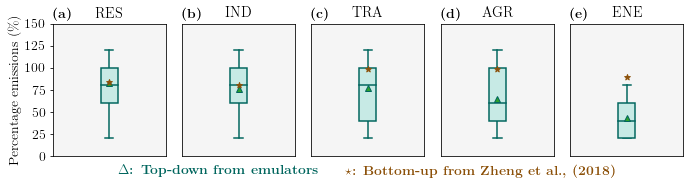

In [41]:
fig = plt.figure(1, figsize=(15, 3))
gs = gridspec.GridSpec(1, 5)

region = 'China'

make_boxplot(0, factors_all[f'{region}_RES'].values(), 'RES', zhang2018_bottomup20152017_allspecies_res)
make_boxplot(1, factors_all[f'{region}_IND'].values(), 'IND', zhang2018_bottomup20152017_allspecies_ind)
make_boxplot(2, factors_all[f'{region}_TRA'].values(), 'TRA', zhang2018_bottomup20152017_allspecies_tra)
make_boxplot(3, factors_all[f'{region}_AGR'].values(), 'AGR', zhang2018_bottomup20152017_allspecies_agr)
make_boxplot(4, factors_all[f'{region}_ENE'].values(), 'ENE', zhang2018_bottomup20152017_allspecies_ene)

gs.tight_layout(fig, rect=[0, 0, 0.65, 0.85])

plt.annotate(r'\textbf{$\Delta$: Top-down from emulators}', xy=(-4.0, -0.15), xycoords='axes fraction', fontsize=14, color='#01665e')
plt.annotate(r'\textbf{$\star$: Bottom-up from Zheng et al., (2018)}', xy=(-2.0, -0.15), xycoords='axes fraction', fontsize=14, color='#8c510a')

plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_factors_boxplot_top1000_{region}_{matching_method}_adjusted_scaled_2017vs2015.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_factors_boxplot_top1000_{region}_{matching_method}_adjusted_scaled_2017vs2015.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [237]:
# baselines_mean = {}
# targets_mean = {}
# target_diffs_mean = {}
# regions = ['China', 'GBA', 'North China', 'North East China', 'East China', 'South Central China', 'South West China', 'North West China']
# for output in ['PM2_5_DRY', 'o3_6mDM8h']:
#     for region in regions:
#         values = []
#         for key, value in regional_baselines[region].items():
#             if output in key and value is not np.nan:
#                 values.append(value)

#         values = np.array(values)
#         baselines_mean.update({f'{region}_{output}': np.nanmean(values)})

#         values = []
#         for key, value in regional_targets[region].items():
#             if output in key and value is not np.nan:
#                 values.append(value)

#         values = np.array(values)
#         targets_mean.update({f'{region}_{output}': np.nanmean(values)})

#         values = []
#         for key, value in regional_target_diffs[region].items():
#             if output in key and value is not np.nan:
#                 values.append(value)

#         values = np.array(values)
#         target_diffs_mean.update({f'{region}_{output}': np.nanmean(values)})

In [239]:
# for output in ['PM2_5_DRY', 'o3_6mDM8h']:
#     for region in ['China']: #regions
#         print(region, output)
#         percent_change = (100 * ( baselines_mean[f'{region}_{output}'] + target_diffs_mean[f'{region}_{output}'] ) / baselines_mean[f'{region}_{output}']) - 100
#         print(f"Baseline = {round(baselines_mean[f'{region}_{output}'], 1)}")
#         print(f"Target = {round(targets_mean[f'{region}_{output}'], 1)}")
#         #print(f"Absolute change = {round(target_diffs_mean[f'{region}_{output}'], 1)}")
#         print(f"Percentage change = {round(percent_change, 1)} %")
#         print()

In [29]:
print('RES', round(zhang2018_bottomup20152017_allspecies_res, 2))
print('IND', round(zhang2018_bottomup20152017_allspecies_ind, 2))
print('TRA', round(zhang2018_bottomup20152017_allspecies_tra, 2))
print('AGR', round(zhang2018_bottomup20152017_allspecies_agr, 2))
print('ENE', round(zhang2018_bottomup20152017_allspecies_ene, 2))

RES 0.84
IND 0.81
TRA 0.99
AGR 0.99
ENE 0.89


In [61]:
def get_factors(year, regional_keys, number_of_matches, matching_method, top_down_emission_config_filenames_options):
    factors_all = {}

    for region in regions_all:
        factors_res = {}
        factors_ind = {}
        factors_tra = {}
        factors_agr = {}
        factors_ene = {}
        for index, items in enumerate(list(itertools.islice(regional_keys[f'{region}_{matching_method}'].items(), number_of_matches))):
            factor_res, factor_ind, factor_tra, factor_agr, factor_ene = [float(item) for item in re.findall('\d+\.\d+',  items[0])]
            factors_res.update({index: factor_res})
            factors_ind.update({index: factor_ind})
            factors_tra.update({index: factor_tra})
            factors_agr.update({index: factor_agr})
            factors_ene.update({index: factor_ene})

        factors_all.update({f'{region}_RES': factors_res})
        factors_all.update({f'{region}_IND': factors_ind})
        factors_all.update({f'{region}_TRA': factors_tra})
        factors_all.update({f'{region}_AGR': factors_agr})
        factors_all.update({f'{region}_ENE': factors_ene})

    sectors = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
    color1 = '#c7eae5'
    color2 = '#01665e'

    region = 'China'
    #print(matching_method)
    
    sector_values = {}
    
    for sector in sectors:
        bp = plt.boxplot(
            factors_all[f'{region}_{sector}'].values(), 
            patch_artist=True,
            boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
            capprops={'color': color2, 'linewidth': 1.5},
            whiskerprops={'color': color2, 'linewidth': 1.5},
            flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
            medianprops={'color': color2, 'linewidth': 1.5},
            showmeans=True,
            meanprops={'markeredgecolor': color2, 'color': color2},
            showfliers=False,
            whis=(5, 95),
            zorder=1
        )
        #print(f"{sector}, mean   = {round(bp['means'][0].get_ydata()[0], 3):.3f}")
        #print(f"{sector}, median = {round(bp['medians'][0].get_ydata()[0], 2):.2f}")
        sector_values.update({sector: round(bp['means'][0].get_ydata()[0], 3)})
    #print()
    if '2015' not in top_down_emission_config_filenames_options[matching_method]:
        top_down_emission_config_filenames_options[matching_method].update({'2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'})
            
    top_down_emission_config_filenames_options[matching_method].update({year: f"RES{sector_values['RES']:.3f}_IND{sector_values['IND']:.3f}_TRA{sector_values['TRA']:.3f}_AGR{sector_values['AGR']:.3f}_ENE{sector_values['ENE']:.3f}"})

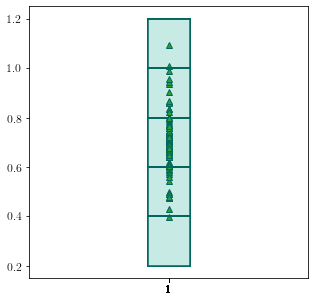

In [62]:
top_down_emission_config_filenames_options = {
    'both': {},
    'either': {},
    'PM2_5_DRY': {},
    'o3_6mDM8h': {}
}

year_keys = {
    '2016': regional_keys_unique_sorted_2016, 
    '2017': regional_keys_unique_sorted_2017, 
    '2018': regional_keys_unique_sorted_2018, 
    '2019': regional_keys_unique_sorted_2019, 
    '2020': regional_keys_unique_sorted_2020}

for matching_method in ['both', 'either', 'PM2_5_DRY', 'o3_6mDM8h']:
    for year, keys in year_keys.items():
        get_factors(year, keys, 1000, matching_method, top_down_emission_config_filenames_options)

In [63]:
top_down_emission_config_filenames_options

{'both': {'2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
  '2016': 'RES0.760_IND0.934_TRA0.735_AGR0.683_ENE0.708',
  '2017': 'RES0.704_IND0.786_TRA0.730_AGR0.659_ENE0.600',
  '2018': 'RES0.712_IND0.703_TRA0.725_AGR0.676_ENE0.649',
  '2019': 'RES0.739_IND0.668_TRA0.701_AGR0.686_ENE0.682',
  '2020': 'RES0.670_IND0.609_TRA0.709_AGR0.621_ENE0.661'},
 'either': {'2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
  '2016': 'RES0.744_IND0.904_TRA0.778_AGR0.678_ENE0.716',
  '2017': 'RES0.771_IND0.835_TRA0.711_AGR0.685_ENE0.544',
  '2018': 'RES0.647_IND0.945_TRA0.746_AGR0.588_ENE0.473',
  '2019': 'RES0.657_IND0.745_TRA0.714_AGR0.613_ENE0.591',
  '2020': 'RES0.582_IND0.700_TRA0.672_AGR0.500_ENE0.492'},
 'PM2_5_DRY': {'2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
  '2016': 'RES0.803_IND0.835_TRA0.742_AGR0.710_ENE0.717',
  '2017': 'RES0.721_IND0.863_TRA0.712_AGR0.740_ENE0.709',
  '2018': 'RES0.661_IND0.674_TRA0.694_AGR0.742_ENE0.715',
  '2019': 'RES0.701_IND0.642_TRA0.669_AGR0.681_ENE0.679',
  '2020': '

In [65]:
bottom_up_emission_config_filenames = {
    '2010': 'RES1.15_IND1.27_TRA0.98_AGR0.98_ENE1.36',
    '2011': 'RES1.19_IND1.30_TRA1.01_AGR1.01_ENE1.46',
    '2012': 'RES1.20_IND1.30_TRA1.01_AGR1.02_ENE1.39',
    '2013': 'RES1.13_IND1.29_TRA1.02_AGR1.01_ENE1.29',
    '2014': 'RES1.06_IND1.12_TRA0.99_AGR1.01_ENE1.12',
    '2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
    '2016': 'RES0.92_IND0.84_TRA0.97_AGR0.99_ENE0.94',
    '2017': 'RES0.84_IND0.81_TRA0.99_AGR0.99_ENE0.89',
}

In [70]:
bottom_up_years = np.asarray([int(year) for year in bottom_up_emission_config_filenames.keys()])
bottom_up_res = np.asarray([float(re.findall(r'RES\d+.\d+', value)[0].split('RES')[1]) for key, value in bottom_up_emission_config_filenames.items()])
bottom_up_ind = np.asarray([float(re.findall(r'IND\d+.\d+', value)[0].split('IND')[1]) for key, value in bottom_up_emission_config_filenames.items()])
bottom_up_tra = np.asarray([float(re.findall(r'TRA\d+.\d+', value)[0].split('TRA')[1]) for key, value in bottom_up_emission_config_filenames.items()])
bottom_up_agr = np.asarray([float(re.findall(r'AGR\d+.\d+', value)[0].split('AGR')[1]) for key, value in bottom_up_emission_config_filenames.items()])
bottom_up_ene = np.asarray([float(re.findall(r'ENE\d+.\d+', value)[0].split('ENE')[1]) for key, value in bottom_up_emission_config_filenames.items()])

top_down_years = np.asarray([int(year) for year in top_down_emission_config_filenames.keys()])
top_down_res = np.asarray([float(re.findall(r'RES\d+.\d+', value)[0].split('RES')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_ind = np.asarray([float(re.findall(r'IND\d+.\d+', value)[0].split('IND')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_tra = np.asarray([float(re.findall(r'TRA\d+.\d+', value)[0].split('TRA')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_agr = np.asarray([float(re.findall(r'AGR\d+.\d+', value)[0].split('AGR')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_ene = np.asarray([float(re.findall(r'ENE\d+.\d+', value)[0].split('ENE')[1]) for key, value in top_down_emission_config_filenames.items()])

In [68]:
def make_emissions_plot():
    ax = fig.add_subplot(gs[0])
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.xlim([2010, 2020])
    plt.ylim([0.0, 1.5])
    plt.xlabel('Years', fontsize=14)
    plt.ylabel('Percentage emissions ({\%})', fontsize=14)
    plt.title('Emission configurations')
    plt.plot(bottom_up_years, bottom_up_res, color='#1b9e77', label='RES', linewidth=2.0)
    plt.plot(bottom_up_years, bottom_up_ind, color='#d95f02', label='IND', linewidth=2.0)
    plt.plot(bottom_up_years, bottom_up_tra, color='#7570b3', label='TRA', linewidth=2.0)
    plt.plot(bottom_up_years, bottom_up_agr, color='#66a61e', label='AGR', linewidth=2.0)
    plt.plot(bottom_up_years, bottom_up_ene, color='#e6ab02', label='ENE', linewidth=2.0)
    plt.plot(top_down_years, top_down_res, color='#1b9e77', linestyle='dashed', linewidth=2.0)
    plt.plot(top_down_years, top_down_ind, color='#d95f02', linestyle='dashed', linewidth=2.0)
    plt.plot(top_down_years, top_down_tra, color='#7570b3', linestyle='dashed', linewidth=2.0)
    plt.plot(top_down_years, top_down_agr, color='#66a61e', linestyle='dashed', linewidth=2.0)
    plt.plot(top_down_years, top_down_ene, color='#e6ab02', linestyle='dashed', linewidth=2.0)
    plt.legend(loc='lower left', fontsize=12)

    leg_1 = matplotlib.lines.Line2D([], [], color='#1b9e77', linewidth=2.0, label='RES')
    leg_2 = matplotlib.lines.Line2D([], [], color='#d95f02', linewidth=2.0, label='IND')
    leg_3 = matplotlib.lines.Line2D([], [], color='#7570b3', linewidth=2.0, label='TRA')
    leg_4 = matplotlib.lines.Line2D([], [], color='#66a61e', linewidth=2.0, label='AGR')
    leg_5 = matplotlib.lines.Line2D([], [], color='#e6ab02', linewidth=2.0, label='ENE')
    leg_6 = matplotlib.lines.Line2D([], [], color='black', linewidth=2.0, label='Bottom-up')
    leg_7 = matplotlib.lines.Line2D([], [], color='black', linewidth=2.0, label='Top-down', linestyle='dashed')

    gs.tight_layout(fig, rect=[0, 0, 1, 1])

    bb = (fig.subplotpars.left - 0.11, fig.subplotpars.top - 0.43, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
    plt.legend(
        fontsize=10, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=1, #frameon=False,
        handles=[leg_1, leg_2, leg_3, leg_4, leg_5, leg_6, leg_7], #mode='expand', #borderaxespad=0., 
        bbox_transform=fig.transFigure
    )

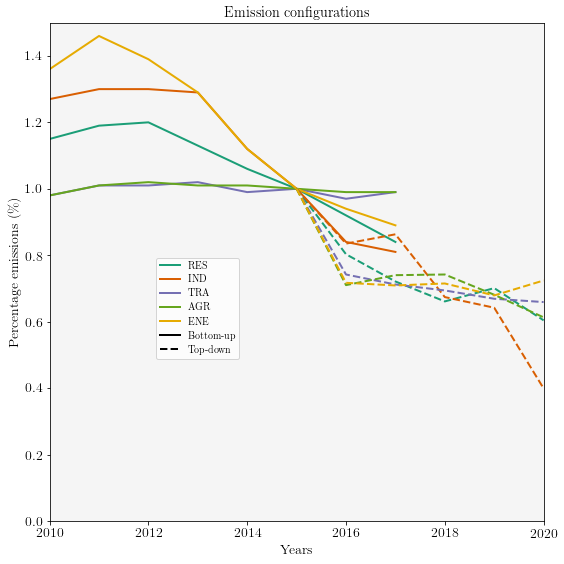

In [82]:
top_down_emission_config_filenames = top_down_emission_config_filenames_options['PM2_5_DRY'].copy()

emission_config_filenames = {
    'bottom_up': bottom_up_emission_config_filenames,
    'top_down': top_down_emission_config_filenames,
}
top_down_res = np.asarray([float(re.findall(r'RES\d+.\d+', value)[0].split('RES')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_ind = np.asarray([float(re.findall(r'IND\d+.\d+', value)[0].split('IND')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_tra = np.asarray([float(re.findall(r'TRA\d+.\d+', value)[0].split('TRA')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_agr = np.asarray([float(re.findall(r'AGR\d+.\d+', value)[0].split('AGR')[1]) for key, value in top_down_emission_config_filenames.items()])
top_down_ene = np.asarray([float(re.findall(r'ENE\d+.\d+', value)[0].split('ENE')[1]) for key, value in top_down_emission_config_filenames.items()])

fig = plt.figure(1, figsize=(8, 8))
gs = gridspec.GridSpec(1, 1)
make_emissions_plot()
plt.show()

### Plot - Health impact assessments

In [ ]:
# top 100
# if matching_method == 'both':
#     top_down_emission_config_filenames = {
#         '2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
#         '2016': 'RES0.95_IND0.99_TRA0.71_AGR0.88_ENE0.69',
#         '2017': 'RES0.89_IND0.90_TRA0.79_AGR0.74_ENE0.59',
#         '2018': 'RES0.71_IND0.91_TRA0.84_AGR0.53_ENE0.54',
#         '2019': 'RES0.72_IND0.88_TRA0.73_AGR0.71_ENE0.63',
#         '2020': 'RES0.64_IND0.79_TRA0.63_AGR0.56_ENE0.44',
#     }
# elif matching_method == 'either':
#     top_down_emission_config_filenames = {
#         '2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
#         '2016': 'RES0.96_IND0.93_TRA0.68_AGR0.87_ENE0.76',
#         '2017': 'RES0.96_IND0.92_TRA0.75_AGR0.83_ENE0.46',
#         '2018': 'RES0.86_IND1.08_TRA0.82_AGR0.52_ENE0.49',
#         '2019': 'RES0.87_IND0.94_TRA0.71_AGR0.59_ENE0.50',
#         '2020': 'RES0.79_IND0.79_TRA0.60_AGR0.42_ENE0.44',
#     }
# elif matching_method == 'PM2_5_DRY':
#     top_down_emission_config_filenames = {
#         '2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
#         '2016': 'RES1.01_IND0.82_TRA0.77_AGR0.94_ENE0.73',
#         '2017': 'RES0.88_IND0.88_TRA0.75_AGR0.91_ENE0.70',
#         '2018': 'RES0.79_IND0.85_TRA0.74_AGR0.85_ENE0.83',
#         '2019': 'RES0.83_IND0.71_TRA0.82_AGR0.89_ENE0.79',
#         '2020': 'RES0.94_IND0.38_TRA0.65_AGR0.74_ENE0.72',
#     }
# elif matching_method == 'o3_6mDM8h':
#     top_down_emission_config_filenames = {
#         '2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
#         '2016': 'RES0.76_IND1.08_TRA0.56_AGR0.77_ENE0.86',
#         '2017': 'RES0.94_IND0.67_TRA0.74_AGR0.72_ENE0.37',
#         '2018': 'RES0.93_IND1.11_TRA0.93_AGR0.64_ENE0.40',
#         '2019': 'RES0.94_IND1.12_TRA0.61_AGR0.48_ENE0.35',
#         '2020': 'RES0.94_IND0.99_TRA0.66_AGR0.50_ENE0.43',
#     }

In [83]:
#matching_method = 'both'
#matching_method = 'either'
matching_method = 'PM2_5_DRY'
#matching_method = 'o3_6mDM8h'

top_down_emission_config_filenames = top_down_emission_config_filenames_options[matching_method].copy()

emission_config_filenames = {
    'bottom_up': bottom_up_emission_config_filenames,
    'top_down': top_down_emission_config_filenames,
}

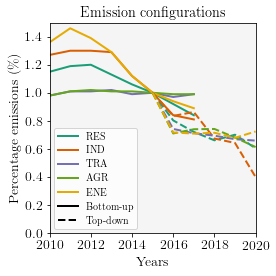

In [84]:
fig = plt.figure(1, figsize=(4, 4))
gs = gridspec.GridSpec(1, 1)

make_emissions_plot()

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_configs_adjusted_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_configs_adjusted_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [94]:
custom_inputs_main = []
for matching_method, top_down_emission_config_filenames in top_down_emission_config_filenames_options.items():
    for year, emission_config in top_down_emission_config_filenames.items():
        custom_inputs_main.append(np.array([float(num) for num in re.findall(r'\d+.\d+', emission_config)]).reshape(1, -1))

In [95]:
custom_inputs_main

[array([[1., 1., 1., 1., 1.]]),
 array([[0.76 , 0.934, 0.735, 0.683, 0.708]]),
 array([[0.704, 0.786, 0.73 , 0.659, 0.6  ]]),
 array([[0.712, 0.703, 0.725, 0.676, 0.649]]),
 array([[0.739, 0.668, 0.701, 0.686, 0.682]]),
 array([[0.67 , 0.609, 0.709, 0.621, 0.661]]),
 array([[1., 1., 1., 1., 1.]]),
 array([[0.744, 0.904, 0.778, 0.678, 0.716]]),
 array([[0.771, 0.835, 0.711, 0.685, 0.544]]),
 array([[0.647, 0.945, 0.746, 0.588, 0.473]]),
 array([[0.657, 0.745, 0.714, 0.613, 0.591]]),
 array([[0.582, 0.7  , 0.672, 0.5  , 0.492]]),
 array([[1., 1., 1., 1., 1.]]),
 array([[0.803, 0.835, 0.742, 0.71 , 0.717]]),
 array([[0.721, 0.863, 0.712, 0.74 , 0.709]]),
 array([[0.661, 0.674, 0.694, 0.742, 0.715]]),
 array([[0.701, 0.642, 0.669, 0.681, 0.679]]),
 array([[0.604, 0.399, 0.659, 0.613, 0.724]]),
 array([[1., 1., 1., 1., 1.]]),
 array([[0.769, 1.009, 0.697, 0.69 , 0.72 ]]),
 array([[0.824, 0.759, 0.767, 0.641, 0.429]]),
 array([[0.858, 1.092, 0.794, 0.604, 0.475]]),
 array([[0.8  , 0.987, 0.6

In [320]:
path_hia = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments'

outputs = ['PM2_5_DRY', 'o3_6mDM8h']
outcomes = ['mort', 'dalys_rate']

sims_set = set(['RES', 'IND', 'TRA', 'AGR', 'ENE'])
labels_output = {
    'PM2_5_DRY': 'PM$_{2.5}$ exposure',
    'o3_6mDM8h': 'O$_3$ exposure',
}
labels = {
    'PM2_5_DRY_mort': 'MORT from PM$_{2.5}$ exposure ($deaths$ $y^{-1}$)',
    'PM2_5_DRY_dalys_rate': 'DALYS rate from PM$_{2.5}$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
    'o3_6mDM8h_mort': 'MORT from O$_3$ exposure ($deaths$ $y^{-1}$)',
    'o3_6mDM8h_dalys_rate': 'DALYS rate from O$_3$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
}
outcomes_mort = {
    'PM2_5_DRY': 'mort_ncdlri_mean_total',
    'o3_6mDM8h': 'mort_copd_mean_total',
}
outcomes_dalys_rate = {
    'PM2_5_DRY': 'dalys_rate_ncdlri_mean_total',
    'o3_6mDM8h': 'dalys_rate_copd_mean_total',
}
regions = {
    'North China': ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Nei Mongol'],
    'North East China': ['Liaoning', 'Jilin', 'Heilongjiang'],
    'East China': ['Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong'],
    'South Central China': ['Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan'],
    'South West China': ['Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang'],
    'North West China': ['Shaanxi', 'Gansu', 'Qinghai', 'Ningxia Hui', 'Xinjiang Uygur']
}
# GBA = Dongguan, Foshan, Guangzhou, Huizhou, Jiangmen, Shenzhen, Zhaoqing, Zhongshan, Zhuhai, Hong Kong, and Macao

regions_all = ['China', 'GBA'] + list(regions.keys())

In [321]:
results_compare = {}
outcomes_keys_compare = {
    'exposure_PM2_5_DRY_mean': 'pm25_popweighted',
    'exposure_o3_6mDM8h_mean': 'o3_popweighted',
    'mort_PM2_5_DRY_mean': 'mort_ncdlri_mean_total',
    'mort_o3_6mDM8h_mean': 'mort_copd_mean_total',
    'mort_PM2_5_DRY_lower': 'mort_ncdlri_lower_total',
    'mort_o3_6mDM8h_lower': 'mort_copd_lower_total',
    'mort_PM2_5_DRY_upper': 'mort_ncdlri_upper_total',
    'mort_o3_6mDM8h_upper': 'mort_copd_upper_total',
    'dalys_rate_PM2_5_DRY_mean': 'dalys_rate_ncdlri_mean_total',
    'dalys_rate_o3_6mDM8h_mean': 'dalys_rate_copd_mean_total',
    'dalys_rate_PM2_5_DRY_lower': 'dalys_rate_ncdlri_lower_total',
    'dalys_rate_o3_6mDM8h_lower': 'dalys_rate_copd_lower_total',
    'dalys_rate_PM2_5_DRY_upper': 'dalys_rate_ncdlri_upper_total',
    'dalys_rate_o3_6mDM8h_upper': 'dalys_rate_copd_upper_total',
}

for region in regions_all:
    results_compare.update({region: {}})
    for output in outputs:
        results_compare[region].update({output: {}})
        for outcome in ['exposure', 'mort', 'dalys_rate']:
            results_compare[region][output].update({outcome: {}})
            for metric in ['mean', 'lower', 'upper']:
                results_compare[region][output][outcome].update({metric: {}})

In [322]:
for method in ['bottom_up', 'top_down']:
    for year, emission_config_filename in emission_config_filenames[method].items():
        for output in ['PM2_5_DRY', 'o3_6mDM8h']:
            df_country = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_country_hia_{output}_{emission_config_filename}_adjusted_scaled.csv')
            df_province = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_province_hia_{output}_{emission_config_filename}_adjusted_scaled.csv')
            df_prefecture = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_prefecture_hia_{output}_{emission_config_filename}_adjusted_scaled.csv')

            for region in regions_all:
                for outcome in ['exposure', 'mort', 'dalys_rate']:
                    for metric in ['mean', 'lower', 'upper']:
                        if outcome == 'exposure' and metric != 'mean':
                            continue
                        if region == 'China':
                            result = df_country.loc[df_country.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                        if outcome == 'mort': # sum number of mortalities over regions
                            if region == 'GBA':
                                result = df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                            if region in regions.keys():
                                result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                        if outcome == 'dalys_rate' or outcome  == 'exposure': # find the mean over the regions for dalys rate and exposure
                            if region == 'GBA':
                                values = np.concatenate((df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values), axis=0)
                                values[values == 0.0] = np.nan
                                result = np.nanmean(values)
                            if region in regions.keys():
                                values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values
                                values[values == 0.0] = np.nan
                                result = np.nanmean(values)


                        results_compare[region][output][outcome][metric].update({f'{method}_{year}': result})

In [323]:
bottom_up = {}
top_down = {}
years = np.arange(2010, 2021)
for region in regions_all:
    for output in outputs:
        for outcome in ['exposure', 'mort', 'dalys_rate']:
            for metric in ['mean', 'lower', 'upper']:
                if (outcome == 'exposure' and metric == 'lower') or (outcome == 'exposure' and metric == 'upper'):
                    continue
                else:
                    bottom_up_values = []
                    top_down_values = []

                    for year in years:
                        if year <= 2017:
                            bottom_up_values.append(results_compare[region][output][outcome][metric][f'bottom_up_{str(year)}'])
                        else:
                            bottom_up_values.append(np.nan)

                        if year <= 2014:
                            top_down_values.append(np.nan)
                        else:
                            top_down_values.append(results_compare[region][output][outcome][metric][f'top_down_{str(year)}'])

                        bottom_up.update({f'{region}_{output}_{outcome}_{metric}': np.asarray(bottom_up_values, dtype=float)})
                        top_down.update({f'{region}_{output}_{outcome}_{metric}': np.asarray(top_down_values, dtype=float)})

In [325]:
joblib.dump(results_compare, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/results_compare_original_{matching_method}.joblib')
joblib.dump(bottom_up, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/bottom_up_original_{matching_method}.joblib')
joblib.dump(top_down, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/top_down_original_{matching_method}.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/top_down_original_PM2_5_DRY.joblib']

In [31]:
results_compare = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/results_compare_original_{matching_method}.joblib')
bottom_up = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/bottom_up_original_{matching_method}.joblib')
top_down = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/top_down_original_{matching_method}.joblib')

In [17]:
comma_format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
region_colors = {
    'China': '#8c510a',
    'GBA': '#d95f02',
    'North China': '#7570b3',
    'North East China': '#e7298a',
    'East China': '#66a61e',
    'South Central China': '#e6ab02',
    'South West China': '#1b9e77',
    'North West China': '#666666'
}

def make_plot(index, letter, bottom_up, top_down, regions, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + letter + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.get_major_locator().set_params(integer=True)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    plt.xlim([2010, 2020])
    for region in regions:
        if region == 'China':
            plt.plot(years, bottom_up[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o', label='Bottom-up')
            plt.plot(years, top_down[f'{region}_{output}_{outcome}_mean'], color='#01665e', marker='o', label='Top-down')
        else:
            plt.plot(years, bottom_up[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o')
            plt.plot(years, top_down[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o', alpha=0.5)
        if outcome != 'exposure':
            if region == 'China':
                plt.fill_between(years, bottom_up[f'{region}_{output}_{outcome}_lower'], bottom_up[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.5)
                plt.fill_between(years, top_down[f'{region}_{output}_{outcome}_lower'], top_down[f'{region}_{output}_{outcome}_upper'], facecolor='#01665e', alpha=0.5)
            else:
                plt.fill_between(years, bottom_up[f'{region}_{output}_{outcome}_lower'], bottom_up[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.5)
                plt.fill_between(years, top_down[f'{region}_{output}_{outcome}_lower'], top_down[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.2)

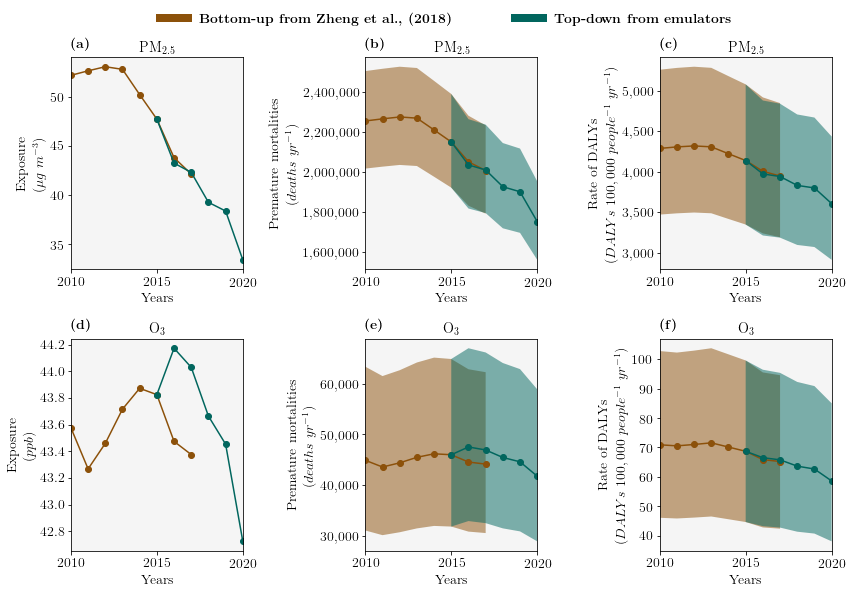

In [266]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

make_plot(0, 'a', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'exposure', 'Exposure\n(${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
make_plot(1, 'b', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(2, 'c', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(3, 'd', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'exposure', 'Exposure\n($ppb$)', 'O$_{3}$')
make_plot(4, 'e', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
make_plot(5, 'f', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'O$_{3}$')

leg_1 = matplotlib.lines.Line2D([], [], color=region_colors['China'], linewidth=8.0, label=r'\textbf{Bottom-up from Zheng et al., (2018)}')
leg_2 = matplotlib.lines.Line2D([], [], color='#01665e', linewidth=8.0, label=r'\textbf{Top-down from emulators}')

gs.tight_layout(fig, rect=[0, 0, 1, 1])

bb = (fig.subplotpars.left + 0.06, fig.subplotpars.top + 0.05, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
plt.legend(
    fontsize=14, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=2, frameon=False,
    handles=[leg_1, leg_2], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_china_adjusted_scaled_{matching_method}.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_china_adjusted_scaled_{matching_method}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

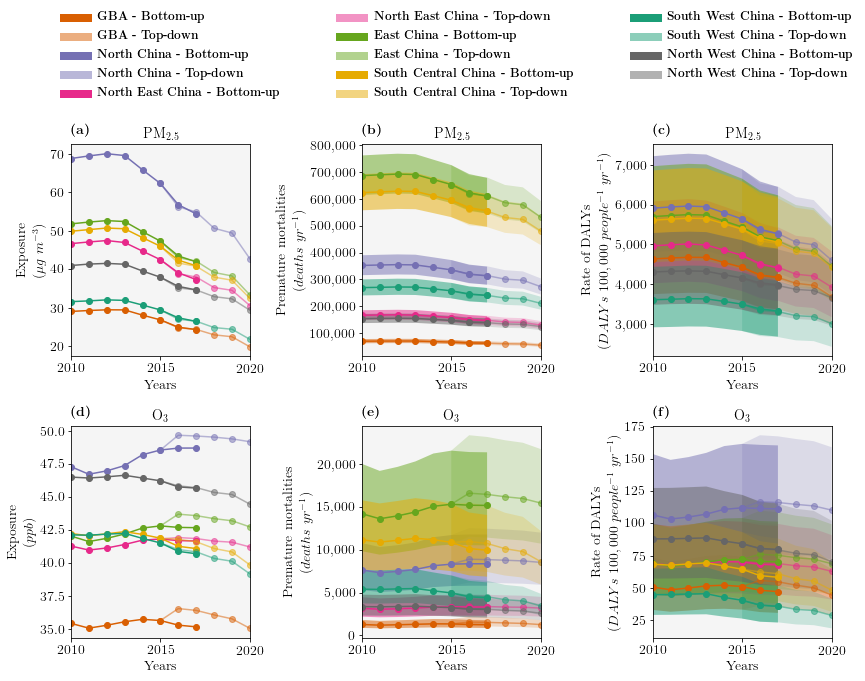

In [267]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

make_plot(0, 'a', bottom_up, top_down, regions_all[1:], 'PM2_5_DRY', 'exposure', 'Exposure\n(${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
make_plot(1, 'b', bottom_up, top_down, regions_all[1:], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(2, 'c', bottom_up, top_down, regions_all[1:], 'PM2_5_DRY', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(3, 'd', bottom_up, top_down, regions_all[1:], 'o3_6mDM8h', 'exposure', 'Exposure\n($ppb$)', 'O$_{3}$')
make_plot(4, 'e', bottom_up, top_down, regions_all[1:], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
make_plot(5, 'f', bottom_up, top_down, regions_all[1:], 'o3_6mDM8h', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'O$_{3}$')

leg_1 = matplotlib.lines.Line2D([], [], color=region_colors['GBA'], linewidth=8.0, label=r'\textbf{GBA - Bottom-up}')
leg_2 = matplotlib.lines.Line2D([], [], color=region_colors['GBA'], linewidth=8.0, label=r'\textbf{GBA - Top-down}', alpha=0.5)
leg_3 = matplotlib.lines.Line2D([], [], color=region_colors['North China'], linewidth=8.0, label=r'\textbf{North China - Bottom-up}')
leg_4 = matplotlib.lines.Line2D([], [], color=region_colors['North China'], linewidth=8.0, label=r'\textbf{North China - Top-down}', alpha=0.5)
leg_5 = matplotlib.lines.Line2D([], [], color=region_colors['North East China'], linewidth=8.0, label=r'\textbf{North East China - Bottom-up}')
leg_6 = matplotlib.lines.Line2D([], [], color=region_colors['North East China'], linewidth=8.0, label=r'\textbf{North East China - Top-down}', alpha=0.5)
leg_7 = matplotlib.lines.Line2D([], [], color=region_colors['East China'], linewidth=8.0, label=r'\textbf{East China - Bottom-up}')
leg_8 = matplotlib.lines.Line2D([], [], color=region_colors['East China'], linewidth=8.0, label=r'\textbf{East China - Top-down}', alpha=0.5)
leg_9 = matplotlib.lines.Line2D([], [], color=region_colors['South Central China'], linewidth=8.0, label=r'\textbf{South Central China - Bottom-up}')
leg_10 = matplotlib.lines.Line2D([], [], color=region_colors['South Central China'], linewidth=8.0, label=r'\textbf{South Central China - Top-down}', alpha=0.5)
leg_11 = matplotlib.lines.Line2D([], [], color=region_colors['South West China'], linewidth=8.0, label=r'\textbf{South West China - Bottom-up}')
leg_12 = matplotlib.lines.Line2D([], [], color=region_colors['South West China'], linewidth=8.0, label=r'\textbf{South West China - Top-down}', alpha=0.5)
leg_13 = matplotlib.lines.Line2D([], [], color=region_colors['North West China'], linewidth=8.0, label=r'\textbf{North West China - Bottom-up}')
leg_14 = matplotlib.lines.Line2D([], [], color=region_colors['North West China'], linewidth=8.0, label=r'\textbf{North West China - Top-down}', alpha=0.5)

gs.tight_layout(fig, rect=[0, 0, 1, 1])

bb = (fig.subplotpars.left - 0.05, fig.subplotpars.top + 0.2, fig.subplotpars.right - fig.subplotpars.left + 0.15, 0.1)
plt.legend(
    fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=3, frameon=False,
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5, leg_6, leg_7, leg_8, leg_9, leg_10, leg_11, leg_12, leg_13, leg_14], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_regions_adjusted_scaled_{matching_method}.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_regions_adjusted_scaled_{matching_method}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [214]:
for output in ['PM2_5_DRY', 'o3_6mDM8h']: # ['PM2_5_DRY', 'o3_6mDM8h']:
    print(output)
    for outcome in ['mort']: # , ['mort', 'dalys_rate']
        print(outcome)
        for region in regions_all[0:1]: # regions_all[0:1] for China, regions_all[1:] for without China
            print(region)
            mean_bottom_up_2010 = results_compare[region][output][outcome]['mean']['bottom_up_2010']
            mean_bottom_up_2011 = results_compare[region][output][outcome]['mean']['bottom_up_2011']
            mean_bottom_up_2012 = results_compare[region][output][outcome]['mean']['bottom_up_2012']
            mean_bottom_up_2013 = results_compare[region][output][outcome]['mean']['bottom_up_2013']
            mean_bottom_up_2014 = results_compare[region][output][outcome]['mean']['bottom_up_2014']
            mean_bottom_up_2015 = results_compare[region][output][outcome]['mean']['bottom_up_2015']
            mean_bottom_up_2016 = results_compare[region][output][outcome]['mean']['bottom_up_2016']
            mean_bottom_up_2017 = results_compare[region][output][outcome]['mean']['bottom_up_2017']
            mean_top_down_2015 = results_compare[region][output][outcome]['mean']['top_down_2015']
            mean_top_down_2016 = results_compare[region][output][outcome]['mean']['top_down_2016']
            mean_top_down_2017 = results_compare[region][output][outcome]['mean']['top_down_2017']
            mean_top_down_2018 = results_compare[region][output][outcome]['mean']['top_down_2018']
            mean_top_down_2019 = results_compare[region][output][outcome]['mean']['top_down_2019']
            mean_top_down_2020 = results_compare[region][output][outcome]['mean']['top_down_2020']
            lower_bottom_up_2010 = results_compare[region][output][outcome]['lower']['bottom_up_2010']
            upper_bottom_up_2010 = results_compare[region][output][outcome]['upper']['bottom_up_2010']
            lower_bottom_up_2011 = results_compare[region][output][outcome]['lower']['bottom_up_2011']
            upper_bottom_up_2011 = results_compare[region][output][outcome]['upper']['bottom_up_2011']
            lower_bottom_up_2012 = results_compare[region][output][outcome]['lower']['bottom_up_2012']
            upper_bottom_up_2012 = results_compare[region][output][outcome]['upper']['bottom_up_2012']
            lower_bottom_up_2013 = results_compare[region][output][outcome]['lower']['bottom_up_2013']
            upper_bottom_up_2013 = results_compare[region][output][outcome]['upper']['bottom_up_2013']
            lower_bottom_up_2014 = results_compare[region][output][outcome]['lower']['bottom_up_2014']
            upper_bottom_up_2014 = results_compare[region][output][outcome]['upper']['bottom_up_2014']
            lower_bottom_up_2015 = results_compare[region][output][outcome]['lower']['bottom_up_2015']
            upper_bottom_up_2015 = results_compare[region][output][outcome]['upper']['bottom_up_2015']
            lower_bottom_up_2016 = results_compare[region][output][outcome]['lower']['bottom_up_2016']
            upper_bottom_up_2016 = results_compare[region][output][outcome]['upper']['bottom_up_2016']
            lower_bottom_up_2017 = results_compare[region][output][outcome]['lower']['bottom_up_2017']
            upper_bottom_up_2017 = results_compare[region][output][outcome]['upper']['bottom_up_2017']
            lower_top_down_2015 = results_compare[region][output][outcome]['lower']['top_down_2015']
            upper_top_down_2015 = results_compare[region][output][outcome]['upper']['top_down_2015']
            lower_top_down_2016 = results_compare[region][output][outcome]['lower']['top_down_2016']
            upper_top_down_2016 = results_compare[region][output][outcome]['upper']['top_down_2016']
            lower_top_down_2017 = results_compare[region][output][outcome]['lower']['top_down_2017']
            upper_top_down_2017 = results_compare[region][output][outcome]['upper']['top_down_2017']
            lower_top_down_2018 = results_compare[region][output][outcome]['lower']['top_down_2018']
            upper_top_down_2018 = results_compare[region][output][outcome]['upper']['top_down_2018']
            lower_top_down_2019 = results_compare[region][output][outcome]['lower']['top_down_2019']
            upper_top_down_2019 = results_compare[region][output][outcome]['upper']['top_down_2019']
            lower_top_down_2020 = results_compare[region][output][outcome]['lower']['top_down_2020']
            upper_top_down_2020 = results_compare[region][output][outcome]['upper']['top_down_2020']


            if outcome == 'mort':
                round_to = -2
            if outcome == 'dalys_rate':
                round_to = 1
            
            print(f"Bottom up 2010, {outcome} = {int(round(mean_bottom_up_2010, round_to)):,} (95UI: {int(round(lower_bottom_up_2010, round_to)):,} to {int(round(upper_bottom_up_2010, round_to)):,})")
            print(f"Bottom up 2011, {outcome} = {int(round(mean_bottom_up_2011, round_to)):,} (95UI: {int(round(lower_bottom_up_2011, round_to)):,} to {int(round(upper_bottom_up_2011, round_to)):,})")
            print(f"Bottom up 2012, {outcome} = {int(round(mean_bottom_up_2012, round_to)):,} (95UI: {int(round(lower_bottom_up_2012, round_to)):,} to {int(round(upper_bottom_up_2012, round_to)):,})")
            print(f"Bottom up 2013, {outcome} = {int(round(mean_bottom_up_2013, round_to)):,} (95UI: {int(round(lower_bottom_up_2013, round_to)):,} to {int(round(upper_bottom_up_2013, round_to)):,})")
            print(f"Bottom up 2014, {outcome} = {int(round(mean_bottom_up_2014, round_to)):,} (95UI: {int(round(lower_bottom_up_2014, round_to)):,} to {int(round(upper_bottom_up_2014, round_to)):,})")
            print(f"Bottom up 2015, {outcome} = {int(round(mean_bottom_up_2015, round_to)):,} (95UI: {int(round(lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2015, round_to)):,})")
            print(f"Bottom up 2016, {outcome} = {int(round(mean_bottom_up_2016, round_to)):,} (95UI: {int(round(lower_bottom_up_2016, round_to)):,} to {int(round(upper_bottom_up_2016, round_to)):,})")
            print(f"Bottom up 2017, {outcome} = {int(round(mean_bottom_up_2017, round_to)):,} (95UI: {int(round(lower_bottom_up_2017, round_to)):,} to {int(round(upper_bottom_up_2017, round_to)):,})")

            print(f"Top down  2015, {outcome} = {int(round(mean_top_down_2015, round_to)):,} (95UI: {int(round(lower_top_down_2015, round_to)):,} to {int(round(upper_top_down_2015, round_to)):,})")
            print(f"Top down  2016, {outcome} = {int(round(mean_top_down_2016, round_to)):,} (95UI: {int(round(lower_top_down_2016, round_to)):,} to {int(round(upper_top_down_2016, round_to)):,})")
            print(f"Top down  2017, {outcome} = {int(round(mean_top_down_2017, round_to)):,} (95UI: {int(round(lower_top_down_2017, round_to)):,} to {int(round(upper_top_down_2017, round_to)):,})")
            print(f"Top down  2018, {outcome} = {int(round(mean_top_down_2018, round_to)):,} (95UI: {int(round(lower_top_down_2018, round_to)):,} to {int(round(upper_top_down_2018, round_to)):,})")
            print(f"Top down  2019, {outcome} = {int(round(mean_top_down_2019, round_to)):,} (95UI: {int(round(lower_top_down_2019, round_to)):,} to {int(round(upper_top_down_2019, round_to)):,})")
            print(f"Top down  2020, {outcome} = {int(round(mean_top_down_2020, round_to)):,} (95UI: {int(round(lower_top_down_2020, round_to)):,} to {int(round(upper_top_down_2020, round_to)):,})")
            
            print(f"Bottom up 2010 vs 2015, {outcome} change = {int(round(mean_bottom_up_2010 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2010 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2010 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2010 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2011 vs 2015, {outcome} change = {int(round(mean_bottom_up_2011 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2011 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2011 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2011 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2012 vs 2015, {outcome} change = {int(round(mean_bottom_up_2012 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2012 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2012 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2012 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2013 vs 2015, {outcome} change = {int(round(mean_bottom_up_2013 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2013 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2013 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2013 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2014 vs 2015, {outcome} change = {int(round(mean_bottom_up_2014 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2014 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2014 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2014 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2016 vs 2015, {outcome} change = {int(round(mean_bottom_up_2016 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2016 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2016 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2016 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2017 vs 2015, {outcome} change = {int(round(mean_bottom_up_2017 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2017 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2017 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2017 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2017 vs 2012, {outcome} change = {int(round(mean_bottom_up_2017 - mean_bottom_up_2012, round_to)):,} ({int(round(lower_bottom_up_2017 - lower_bottom_up_2012, round_to)):,} to {int(round(upper_bottom_up_2017 - upper_bottom_up_2012, round_to)):,}), {int(round(100 * ((mean_bottom_up_2017 / mean_bottom_up_2012) - 1), 0))}%")

            print(f"Top down  2016 vs 2015, {outcome} change = {int(round(mean_top_down_2016 - mean_top_down_2015, round_to)):,} ({int(round(lower_top_down_2016 - lower_top_down_2015, round_to)):,} to {int(round(upper_top_down_2016 - upper_top_down_2015, round_to)):,}), {int(round(100 * ((mean_top_down_2016 / mean_top_down_2015) - 1), 0))}%")
            print(f"Top down  2017 vs 2015, {outcome} change = {int(round(mean_top_down_2017 - mean_top_down_2015, round_to)):,} ({int(round(lower_top_down_2017 - lower_top_down_2015, round_to)):,} to {int(round(upper_top_down_2017 - upper_top_down_2015, round_to)):,}), {int(round(100 * ((mean_top_down_2017 / mean_top_down_2015) - 1), 0))}%")
            print(f"Top down  2018 vs 2015, {outcome} change = {int(round(mean_top_down_2018 - mean_top_down_2015, round_to)):,} ({int(round(lower_top_down_2018 - lower_top_down_2015, round_to)):,} to {int(round(upper_top_down_2018 - upper_top_down_2015, round_to)):,}), {int(round(100 * ((mean_top_down_2018 / mean_top_down_2015) - 1), 0))}%")
            print(f"Top down  2019 vs 2015, {outcome} change = {int(round(mean_top_down_2019 - mean_top_down_2015, round_to)):,} ({int(round(lower_top_down_2019 - lower_top_down_2015, round_to)):,} to {int(round(upper_top_down_2019 - upper_top_down_2015, round_to)):,}), {int(round(100 * ((mean_top_down_2019 / mean_top_down_2015) - 1), 0))}%")
            print(f"Top down  2020 vs 2015, {outcome} change = {int(round(mean_top_down_2020 - mean_top_down_2015, round_to)):,} ({int(round(lower_top_down_2020 - lower_top_down_2015, round_to)):,} to {int(round(upper_top_down_2020 - upper_top_down_2015, round_to)):,}), {int(round(100 * ((mean_top_down_2020 / mean_top_down_2015) - 1), 0))}%")
            print(f"Top down  2020 vs 2017, {outcome} change = {int(round(mean_top_down_2020 - mean_top_down_2017, round_to)):,} ({int(round(lower_top_down_2020 - lower_top_down_2017, round_to)):,} to {int(round(upper_top_down_2020 - upper_top_down_2017, round_to)):,}), {int(round(100 * ((mean_top_down_2020 / mean_top_down_2017) - 1), 0))}%")
            
            print(f"Top down  2020 vs bottom up 2012, {outcome} change = {int(round(mean_top_down_2020 - mean_bottom_up_2012, round_to)):,} ({int(round(lower_top_down_2020 - lower_bottom_up_2012, round_to)):,} to {int(round(upper_top_down_2020 - upper_bottom_up_2012, round_to)):,}), {int(round(100 * ((mean_top_down_2020 / mean_bottom_up_2012) - 1), 0))}%")

            print(f"Top down vs bottom up 2016, {outcome} change = {int(round(mean_top_down_2016 - mean_bottom_up_2016, round_to)):,} ({int(round(lower_top_down_2016 - lower_bottom_up_2016, round_to)):,} to {int(round(upper_top_down_2016 - upper_bottom_up_2016, round_to)):,}), {int(round(100 * ((mean_top_down_2016 / mean_bottom_up_2016) - 1), 0))}%")
            print(f"Top down vs bottom up 2017, {outcome} change = {int(round(mean_top_down_2017 - mean_bottom_up_2017, round_to)):,} ({int(round(lower_top_down_2017 - lower_bottom_up_2017, round_to)):,} to {int(round(upper_top_down_2017 - upper_bottom_up_2017, round_to)):,}), {int(round(100 * ((mean_top_down_2017 / mean_bottom_up_2017) - 1), 0))}%")
            print()


PM2_5_DRY
mort
China
Bottom up 2010, mort = 2,253,500 (95UI: 2,016,100 to 2,502,100)
Bottom up 2011, mort = 2,264,000 (95UI: 2,025,700 to 2,513,700)
Bottom up 2012, mort = 2,273,400 (95UI: 2,034,300 to 2,523,900)
Bottom up 2013, mort = 2,267,600 (95UI: 2,029,000 to 2,517,600)
Bottom up 2014, mort = 2,208,700 (95UI: 1,975,400 to 2,453,300)
Bottom up 2015, mort = 2,149,000 (95UI: 1,921,100 to 2,388,000)
Bottom up 2016, mort = 2,050,000 (95UI: 1,831,200 to 2,279,700)
Bottom up 2017, mort = 2,006,100 (95UI: 1,791,400 to 2,231,700)
Top down  2015, mort = 2,149,000 (95UI: 1,921,100 to 2,388,000)
Top down  2016, mort = 2,034,300 (95UI: 1,817,000 to 2,262,500)
Top down  2017, mort = 2,009,300 (95UI: 1,794,300 to 2,235,200)
Top down  2018, mort = 1,925,600 (95UI: 1,718,500 to 2,143,400)
Top down  2019, mort = 1,900,600 (95UI: 1,695,800 to 2,115,900)
Top down  2020, mort = 1,751,700 (95UI: 1,561,200 to 1,952,400)
Bottom up 2010 vs 2015, mort change = 104,500 (95,000 to 114,100), 5%
Bottom up 201

In [15]:
# 1,739,500 (95UI: 1,550,200 to 1,938,900)
#    39,500 (95UI: 27,300 to 55,700)
print(1_739_500 + 39_500)
print(1_550_200 + 27_300)
print(1_938_900 + 55_700)

1779000
1577500
1994600


In [269]:
outcome = 'exposure'

for output in ['PM2_5_DRY', 'o3_6mDM8h']:
    print(output)
    print(outcome)
    for region in regions_all[0:1]: # regions_all[0:1] for China, regions_all[1:] for without China
        print(region)
        mean_bottom_up_2010 = results_compare[region][output][outcome]['mean']['bottom_up_2010']
        mean_bottom_up_2011 = results_compare[region][output][outcome]['mean']['bottom_up_2011']
        mean_bottom_up_2012 = results_compare[region][output][outcome]['mean']['bottom_up_2012']
        mean_bottom_up_2013 = results_compare[region][output][outcome]['mean']['bottom_up_2013']
        mean_bottom_up_2014 = results_compare[region][output][outcome]['mean']['bottom_up_2014']
        mean_bottom_up_2015 = results_compare[region][output][outcome]['mean']['bottom_up_2015']
        mean_bottom_up_2016 = results_compare[region][output][outcome]['mean']['bottom_up_2016']
        mean_bottom_up_2017 = results_compare[region][output][outcome]['mean']['bottom_up_2017']
        mean_top_down_2015 = results_compare[region][output][outcome]['mean']['top_down_2015']
        mean_top_down_2016 = results_compare[region][output][outcome]['mean']['top_down_2016']
        mean_top_down_2017 = results_compare[region][output][outcome]['mean']['top_down_2017']
        mean_top_down_2018 = results_compare[region][output][outcome]['mean']['top_down_2018']
        mean_top_down_2019 = results_compare[region][output][outcome]['mean']['top_down_2019']
        mean_top_down_2020 = results_compare[region][output][outcome]['mean']['top_down_2020']

        round_to = 1
        
        print(f"Bottom up 2010, {outcome} = {round(mean_bottom_up_2010, round_to):,}")
        print(f"Bottom up 2011, {outcome} = {round(mean_bottom_up_2011, round_to):,}")
        print(f"Bottom up 2012, {outcome} = {round(mean_bottom_up_2012, round_to):,}")
        print(f"Bottom up 2013, {outcome} = {round(mean_bottom_up_2013, round_to):,}")
        print(f"Bottom up 2014, {outcome} = {round(mean_bottom_up_2014, round_to):,}")
        print(f"Bottom up 2015, {outcome} = {round(mean_bottom_up_2015, round_to):,}")
        print(f"Bottom up 2016, {outcome} = {round(mean_bottom_up_2016, round_to):,}")
        print(f"Bottom up 2017, {outcome} = {round(mean_bottom_up_2017, round_to):,}")

        print(f"Top down  2015, {outcome} = {round(mean_top_down_2015, round_to):,}")
        print(f"Top down  2016, {outcome} = {round(mean_top_down_2016, round_to):,}")
        print(f"Top down  2017, {outcome} = {round(mean_top_down_2017, round_to):,}")
        print(f"Top down  2018, {outcome} = {round(mean_top_down_2018, round_to):,}")
        print(f"Top down  2019, {outcome} = {round(mean_top_down_2019, round_to):,}")
        print(f"Top down  2020, {outcome} = {round(mean_top_down_2020, round_to):,}")
        
        print(f"Bottom up 2010 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2010 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2010 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2011 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2011 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2011 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2012 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2012 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2012 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2013 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2013 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2013 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2014 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2014 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2014 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2016 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2016 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2016 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2017 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2017 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2017 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Bottom up 2017 vs 2012, {outcome} reduction of = {round(mean_bottom_up_2017 - mean_bottom_up_2012, round_to):,}, {round(100 * ((mean_bottom_up_2017 / mean_bottom_up_2012) - 1), 0)}%")

        print(f"Top down  2016 vs 2015, {outcome} reduction of = {round(mean_top_down_2016 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_top_down_2016 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Top down  2017 vs 2015, {outcome} reduction of = {round(mean_top_down_2017 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_top_down_2017 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Top down  2018 vs 2015, {outcome} reduction of = {round(mean_top_down_2018 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_top_down_2018 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Top down  2019 vs 2015, {outcome} reduction of = {round(mean_top_down_2019 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_top_down_2019 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Top down  2020 vs 2015, {outcome} reduction of = {round(mean_top_down_2020 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_top_down_2020 / mean_bottom_up_2015) - 1), 0)}%")
        print(f"Top down  2020 vs 2012, {outcome} reduction of = {round(mean_top_down_2020 - mean_bottom_up_2012, round_to):,}, {round(100 * ((mean_top_down_2020 / mean_bottom_up_2012) - 1), 0)}%")

        print(f"Top down vs bottom up 2016, {outcome} reduction of = {round(mean_top_down_2016 - mean_bottom_up_2016, round_to):,}, {round(100 * ((mean_top_down_2016 / mean_bottom_up_2016) - 1), 0)}%")
        print(f"Top down vs bottom up 2017, {outcome} reduction of = {round(mean_top_down_2017 - mean_bottom_up_2017, round_to):,}, {round(100 * ((mean_top_down_2017 / mean_bottom_up_2017) - 1), 0)}%")
        print()


PM2_5_DRY
exposure
China
Bottom up 2010, exposure = 52.2
Bottom up 2011, exposure = 52.6
Bottom up 2012, exposure = 53.0
Bottom up 2013, exposure = 52.8
Bottom up 2014, exposure = 50.2
Bottom up 2015, exposure = 47.7
Bottom up 2016, exposure = 43.8
Bottom up 2017, exposure = 42.1
Top down  2015, exposure = 47.7
Top down  2016, exposure = 43.2
Top down  2017, exposure = 42.3
Top down  2018, exposure = 39.3
Top down  2019, exposure = 38.4
Top down  2020, exposure = 33.4
Bottom up 2010 vs 2015, exposure reduction of = 4.5, 9.0%
Bottom up 2011 vs 2015, exposure reduction of = 4.9, 10.0%
Bottom up 2012 vs 2015, exposure reduction of = 5.3, 11.0%
Bottom up 2013 vs 2015, exposure reduction of = 5.1, 11.0%
Bottom up 2014 vs 2015, exposure reduction of = 2.5, 5.0%
Bottom up 2016 vs 2015, exposure reduction of = -3.9, -8.0%
Bottom up 2017 vs 2015, exposure reduction of = -5.6, -12.0%
Bottom up 2017 vs 2012, exposure reduction of = -10.9, -21.0%
Top down  2016 vs 2015, exposure reduction of = -4.

In [218]:
# median concentrations across the observation stations
emission_trend_values = {}
station_ids = [key for key in obs_lats.keys()]

# obs
for year in ['2015', '2016', '2017', '2018', '2019', '2020']:
    emission_trend_values.update({f'obs_{year}_PM2_5_DRY': df_obs[year]['PM2_5_DRY'].mean()})
    emission_trend_values.update({f'obs_{year}_o3_6mDM8h': df_obs[year]['o3_6mDM8h_ppb'].mean()})

# bottom up
for year in np.arange(2010, 2018):
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        for station_id in station_ids:
            lat = obs_lats[f'{station_id}']
            lon = obs_lons[f'{station_id}']
            with xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_adjusted_scaled/ds_{bottom_up_emission_config_filenames[str(year)]}_{output}_popgrid_0.25deg_adjusted_scaled.nc').reset_coords()[output] as ds:
                emission_trend_values.update({f'bottom_up_{str(year)}_{output}': float(ds.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').values)})
        
# top down
for year in np.arange(2015, 2021):
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        for station_id in station_ids:
            lat = obs_lats[f'{station_id}']
            lon = obs_lons[f'{station_id}']
            with xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_adjusted_scaled/ds_{top_down_emission_config_filenames[str(year)]}_{output}_popgrid_0.25deg_adjusted_scaled.nc').reset_coords()[output] as ds:
                emission_trend_values.update({f'top_down_{str(year)}_{output}': float(ds.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').values)})

In [219]:
joblib.dump(emission_trend_values, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/emission_trend_values_{matching_method}.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/emission_trend_values_PM2_5_DRY.joblib']

In [26]:
emission_trend_values = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/emission_trend_values_{matching_method}.joblib')

In [27]:
# bens 2018 paper found -3.4 ugm-3 per year over 2015-2017, so -6.8 ugm-3 overall approximately
print('2017 vs 2015')
print()
print('PM2_5_DRY')
print(f"2015: obs = {round(emission_trend_values['obs_2015_PM2_5_DRY'], 1)}, bottom up = {round(emission_trend_values['bottom_up_2015_PM2_5_DRY'], 1)}, top down = {round(emission_trend_values['top_down_2015_PM2_5_DRY'], 1)}")
print(f"2017: obs = {round(emission_trend_values['obs_2017_PM2_5_DRY'], 1)}, bottom up = {round(emission_trend_values['bottom_up_2017_PM2_5_DRY'], 1)}, top down = {round(emission_trend_values['top_down_2017_PM2_5_DRY'], 1)}")
print(f"2017 - 2015: obs = {round(emission_trend_values['obs_2017_PM2_5_DRY'] - emission_trend_values['obs_2015_PM2_5_DRY'], 1)}, bottom up = {round(emission_trend_values['bottom_up_2017_PM2_5_DRY'] - emission_trend_values['bottom_up_2015_PM2_5_DRY'], 1)}, top down = {round(emission_trend_values['top_down_2017_PM2_5_DRY'] - emission_trend_values['top_down_2015_PM2_5_DRY'], 1)}")
print()
# bens 2018 paper found -2.3 ppb per year over 2015-2019, so -4.6 ppb overall approximately
print('o3_6mDM8h')
print(f"2015: obs = {round(emission_trend_values['obs_2015_o3_6mDM8h'], 1)}, bottom up = {round(emission_trend_values['bottom_up_2015_o3_6mDM8h'], 1)}, top down = {round(emission_trend_values['top_down_2015_o3_6mDM8h'], 1)}")
print(f"2017: obs = {round(emission_trend_values['obs_2017_o3_6mDM8h'], 1)}, bottom up = {round(emission_trend_values['bottom_up_2017_o3_6mDM8h'], 1)}, top down = {round(emission_trend_values['top_down_2017_o3_6mDM8h'], 1)}")
print(f"2017 - 2015: obs = {round(emission_trend_values['obs_2017_o3_6mDM8h'] - emission_trend_values['obs_2015_o3_6mDM8h'], 1)}, bottom up = {round(emission_trend_values['bottom_up_2017_o3_6mDM8h'] - emission_trend_values['bottom_up_2015_o3_6mDM8h'], 1)}, top down = {round(emission_trend_values['top_down_2017_o3_6mDM8h'] - emission_trend_values['top_down_2015_o3_6mDM8h'], 1)}")

2017 vs 2015

PM2_5_DRY
2015: obs = 48.1, bottom up = 53.1, top down = 53.1
2017: obs = 43.0, bottom up = 46.7, top down = 47.3
2017 - 2015: obs = -5.1, bottom up = -6.3, top down = -5.7

o3_6mDM8h
2015: obs = 45.4, bottom up = 43.0, top down = 43.0
2017: obs = 52.2, bottom up = 42.7, top down = 43.0
2017 - 2015: obs = 6.9, bottom up = -0.3, top down = -0.0


In [28]:
print('2020 vs 2017')
print()
print('PM2_5_DRY')
print(f"2017: obs = {round(emission_trend_values['obs_2017_PM2_5_DRY'], 1)}, top down = {round(emission_trend_values['top_down_2017_PM2_5_DRY'], 1)}")
print(f"2020: obs = {round(emission_trend_values['obs_2020_PM2_5_DRY'], 1)}, top down = {round(emission_trend_values['top_down_2020_PM2_5_DRY'], 1)}")
print(f"2020 - 2017: obs = {round(emission_trend_values['obs_2020_PM2_5_DRY'] - emission_trend_values['obs_2017_PM2_5_DRY'], 1)}, top down = {round(emission_trend_values['top_down_2020_PM2_5_DRY'] - emission_trend_values['top_down_2017_PM2_5_DRY'], 1)}")
print()
print('o3_6mDM8h')
print(f"2017: obs = {round(emission_trend_values['obs_2017_o3_6mDM8h'], 1)}, top down = {round(emission_trend_values['top_down_2017_o3_6mDM8h'], 1)}")
print(f"2020: obs = {round(emission_trend_values['obs_2020_o3_6mDM8h'], 1)}, top down = {round(emission_trend_values['top_down_2020_o3_6mDM8h'], 1)}")
print(f"2020 - 2017: obs = {round(emission_trend_values['obs_2020_o3_6mDM8h'] - emission_trend_values['obs_2017_o3_6mDM8h'], 1)}, top down = {round(emission_trend_values['top_down_2020_o3_6mDM8h'] - emission_trend_values['top_down_2017_o3_6mDM8h'], 1)}")

2020 vs 2017

PM2_5_DRY
2017: obs = 43.0, top down = 47.3
2020: obs = 35.4, top down = 37.9
2020 - 2017: obs = -7.7, top down = -9.4

o3_6mDM8h
2017: obs = 52.2, top down = 43.0
2020: obs = 53.8, top down = 42.0
2020 - 2017: obs = 1.6, top down = -1.0


In [190]:
1-35.4/48.1

0.2640332640332641

In [29]:
obs_years = np.asarray([re.findall(r'\d+', key)[0] for key in list({key: value for key, value in emission_trend_values.items() if 'obs' in key and 'PM2_5_DRY' in key}.keys())], dtype=int)
obs_PM2_5_DRY = np.asarray(list({key: value for key, value in emission_trend_values.items() if 'obs' in key and 'PM2_5_DRY' in key}.values()), dtype=float)
obs_o3_6mDM8h = np.asarray(list({key: value for key, value in emission_trend_values.items() if 'obs' in key and 'o3_6mDM8h' in key}.values()), dtype=float)

bottom_up_years = np.asarray([re.findall(r'\d+', key)[0] for key in list({key: value for key, value in emission_trend_values.items() if 'bottom_up' in key and 'PM2_5_DRY' in key}.keys())], dtype=int)
bottom_up_PM2_5_DRY = np.asarray(list({key: value for key, value in emission_trend_values.items() if 'bottom_up' in key and 'PM2_5_DRY' in key}.values()), dtype=float)
bottom_up_o3_6mDM8h = np.asarray(list({key: value for key, value in emission_trend_values.items() if 'bottom_up' in key and 'o3_6mDM8h' in key}.values()), dtype=float)

top_down_years = np.asarray([re.findall(r'\d+', key)[0] for key in list({key: value for key, value in emission_trend_values.items() if 'top_down' in key and 'PM2_5_DRY' in key}.keys())], dtype=int)
top_down_PM2_5_DRY = np.asarray(list({key: value for key, value in emission_trend_values.items() if 'top_down' in key and 'PM2_5_DRY' in key}.values()), dtype=float)
top_down_o3_6mDM8h = np.asarray(list({key: value for key, value in emission_trend_values.items() if 'top_down' in key and 'o3_6mDM8h' in key}.values()), dtype=float)

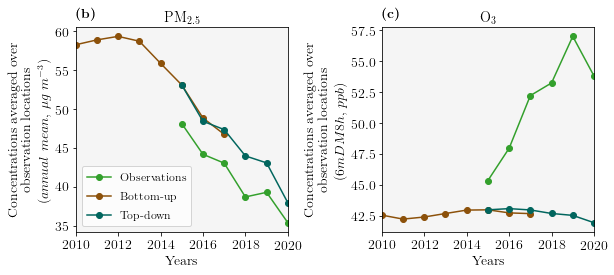

In [32]:
fig = plt.figure(1, figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)

ax = fig.add_subplot(gs[1])
plt.annotate(r'\textbf{(b)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xlim([2010, 2020])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Concentrations averaged over\nobservation locations\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', fontsize=14)
plt.title('PM$_{2.5}$')
plt.plot(obs_years, obs_PM2_5_DRY, color='#33a02c', marker='o', label='Observations')
plt.plot(bottom_up_years, bottom_up_PM2_5_DRY, color=region_colors['China'], marker='o', label='Bottom-up')
plt.plot(top_down_years, top_down_PM2_5_DRY, color='#01665e', marker='o', label='Top-down')
plt.legend()

ax = fig.add_subplot(gs[2])
plt.annotate(r'\textbf{(c)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xlim([2010, 2020])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Concentrations averaged over\nobservation locations\n($6mDM8h,$ $ppb$)', fontsize=14)
plt.title('O$_{3}$')
plt.plot(obs_years, obs_o3_6mDM8h, color='#33a02c', marker='o', label='Observations')
plt.plot(bottom_up_years, bottom_up_o3_6mDM8h, color=region_colors['China'], marker='o', label='Bottom-up')
plt.plot(top_down_years, top_down_o3_6mDM8h, color='#01665e', marker='o', label='Top-down')

gs.tight_layout(fig)

plt.show()

In [34]:
# gbd2019 pm2.5 2019 vs 2010
print(round((gbd2019_pm25_mort_mean[-2] / gbd2019_pm25_mort_mean[0]) - 1, 2))

# hei
print(round((state_of_global_air_pm25[-2] / state_of_global_air_pm25[0]) - 1, 2))


0.2
-0.11


In [33]:
state_of_global_air_pm25 = np.array([53.3, 58.4, 58.9, 63.3, 60.3, 56.2, 51.6, 49.9, 49.3, 47.7, np.nan])
state_of_global_air_o3 = np.array([55.7, 53.8, 51.5, 49.5, 48.7, 49.9, 52.3, 53.6, 49.4, 48.9, np.nan])

gbd2019_pm25_mort_mean = np.array([
    1_185_691.27, 1_228_569.99, 1_258_736.56, 1_293_435, 1_323_022.07, 1_342_078.15,
    1_351_503.52, 1_349_286.39, 1_373_538.89, 1_423_623.59, np.nan,
])
gbd2019_pm25_mort_lower = np.array([
    944_390.71, 995_388.46, 1_024_433.23, 1_054_549.55, 1_086_767.61, 1_094_886.92, 
    1_100_131.56, 1_105_371.61, 1_117_695.9, 1_116_702.92, np.nan,
])
gbd2019_pm25_mort_upper = np.array([
    1_393_625.81, 1_447_124.02, 1_468_272.14, 1_509_502.13, 1_544_260.79, 1_554_160.82,
    1_584_503.79, 1_582_184.42, 1_623_237.18, 1_693_059.37, np.nan,
])

gbd2019_o3_mort_mean = np.array([
    144_975, 132_303.44, 115_859.62, 99_470.18, 91_192.63, 95_369.36,
    107_716, 113_265.32, 93_759.05, 93_271.12, np.nan,
])
gbd2019_o3_mort_lower = np.array([
    68_947.72, 61_725.66, 53_909.3, 45_660.61, 40_739.61, 43_382.88,
    49_563.7, 52_553.31, 42_282.26, 42_664.68, np.nan,
])
gbd2019_o3_mort_upper = np.array([
    222_783.15, 205_056.51, 180_915.59, 159_998.96, 146_796.53, 154_609.15,
    169_081.99, 177_896.15, 152_931.92, 151_062.43, np.nan,
])

gbd2019_pm25_dalys_rate_mean = np.array([
    2_063.26, 2_124.95, 2_175.21, 2_221.81, 2_255.96, 2_278.64, 
    2_226.07, 2_237.30, 2_252.79, 2_310.52, np.nan
])
gbd2019_pm25_dalys_rate_lower = np.array([
    1_627.53, 1_722.38, 1_777.25, 1_789.98, 1_853.63, 1_870.02, 
    1_851.69, 1_825.12, 1_827.38, 1_897.10, np.nan
])
gbd2019_pm25_dalys_rate_upper = np.array([
    2_420.85, 2_507.15, 2_543.28, 2_596, 2_630.8, 2_652.26, 
    2_648.82, 2_611.44, 2_650.89, 2_722.21, np.nan
])

gbd2019_o3_dalys_rate_mean = np.array([
    165.74, 150.2, 130.33, 110.26, 99.55, 103.24, 115.37, 119.98, 98.1, 96.52, np.nan    
])
gbd2019_o3_dalys_rate_lower = np.array([
    78.8, 70.07, 60.52, 50.62, 44.25, 46.7, 53.16, 55.51, 44.3, 44.06, np.nan,     
])
gbd2019_o3_dalys_rate_upper = np.array([
    255.12, 233.07, 202.18, 176.66, 160.42, 167.7, 181.88, 189.14, 161.53, 156.37, np.nan    
])

In [34]:
def make_plot(index, letter, bottom_up, top_down, regions, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + letter + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.get_major_locator().set_params(integer=True)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    plt.xlim([2010, 2020])
    for region in regions:
        if region == 'China':
            plt.plot(years, bottom_up[f'{region}_{output}_{outcome}_mean'], color=paper_colors['Bottom-up'], marker='o', label='Bottom-up')
            plt.plot(years, top_down[f'{region}_{output}_{outcome}_mean'], color=paper_colors['Top-down'], marker='o', label='Top-down')
        else:
            plt.plot(years, bottom_up[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o')
            plt.plot(years, top_down[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o', alpha=0.5)
        if outcome != 'exposure':
            if region == 'China':
                plt.fill_between(years, bottom_up[f'{region}_{output}_{outcome}_lower'], bottom_up[f'{region}_{output}_{outcome}_upper'], facecolor=paper_colors['Bottom-up'], alpha=0.5)
                plt.fill_between(years, top_down[f'{region}_{output}_{outcome}_lower'], top_down[f'{region}_{output}_{outcome}_upper'], facecolor=paper_colors['Top-down'], alpha=0.5)
            else:
                plt.fill_between(years, bottom_up[f'{region}_{output}_{outcome}_lower'], bottom_up[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.5)
                plt.fill_between(years, top_down[f'{region}_{output}_{outcome}_lower'], top_down[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.2)

In [584]:
paper_colors = {
    'Observations': '#a6cee3',
    'Bottom-up': '#1f78b4',
    'Top-down': '#b2df8a',
    'HEI (2020)': '#33a02c',
    'GBD2019 (2020)': '#b15928',
    'Silver et al., (2020)': '#e31a1c',
    'Zhang et al., (2019)': '#fdbf6f',
    'Liang et al., (2020)': '#ff7f00',
    'Huang et al., (2021)': '#cab2d6',
    'Dang and Liao, (2019)': '#6a3d9a',
    'Ding et al., (2019)': '#ffff99',
}
paper_legends = []
for label, color in paper_colors.items():
    paper_legend = matplotlib.lines.Line2D([], [], color=color, marker='o', linewidth=1.0, label=label)
    paper_legends.append(paper_legend)

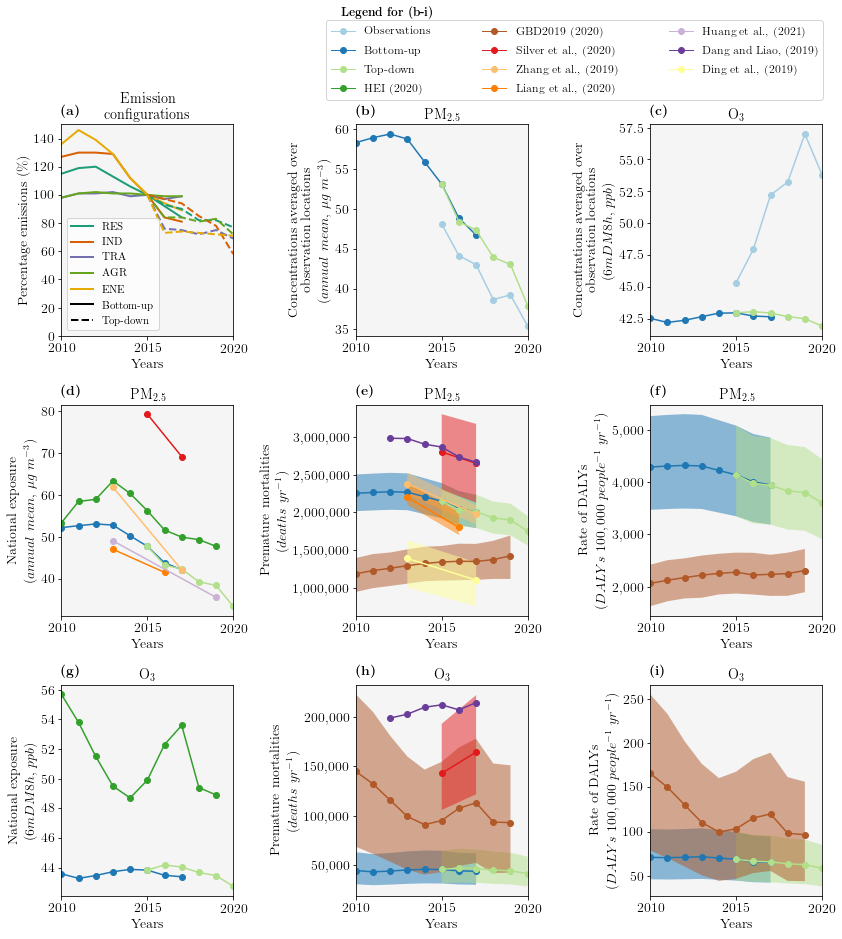

In [35]:
fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax = fig.add_subplot(gs[0])
plt.annotate(r'\textbf{(a)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlim([2010, 2020])
plt.ylim([0.0, 1.5])
plt.yticks(np.arange(0, 1.60, 0.20))
ax.set_yticklabels(np.arange(0, 160, 20))
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage emissions ({\%})', fontsize=14)
plt.title('Emission\nconfigurations')
plt.plot(bottom_up_years, bottom_up_res, color='#1b9e77', label='RES', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_ind, color='#d95f02', label='IND', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_tra, color='#7570b3', label='TRA', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_agr, color='#66a61e', label='AGR', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_ene, color='#e6ab02', label='ENE', linewidth=2.0)
plt.plot(top_down_years, top_down_res, color='#1b9e77', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_ind, color='#d95f02', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_tra, color='#7570b3', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_agr, color='#66a61e', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_ene, color='#e6ab02', linestyle='dashed', linewidth=2.0)
leg_1 = matplotlib.lines.Line2D([], [], color='#1b9e77', linewidth=2.0, label='RES')
leg_2 = matplotlib.lines.Line2D([], [], color='#d95f02', linewidth=2.0, label='IND')
leg_3 = matplotlib.lines.Line2D([], [], color='#7570b3', linewidth=2.0, label='TRA')
leg_4 = matplotlib.lines.Line2D([], [], color='#66a61e', linewidth=2.0, label='AGR')
leg_5 = matplotlib.lines.Line2D([], [], color='#e6ab02', linewidth=2.0, label='ENE')
leg_6 = matplotlib.lines.Line2D([], [], color='black', linewidth=2.0, label='Bottom-up')
leg_7 = matplotlib.lines.Line2D([], [], color='black', linewidth=2.0, label='Top-down', linestyle='dashed')
plt.legend(
    fontsize=11, fancybox=True, loc='lower left', ncol=1,
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5, leg_6, leg_7], 
    bbox_transform=fig.transFigure
)

ax = fig.add_subplot(gs[1])
plt.annotate(r'\textbf{(b)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xlim([2010, 2020])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Concentrations averaged over\nobservation locations\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', fontsize=14)
plt.title('PM$_{2.5}$')
plt.plot(obs_years, obs_PM2_5_DRY, color=paper_colors['Observations'], marker='o', label='Observations')
plt.plot(bottom_up_years, bottom_up_PM2_5_DRY, color=paper_colors['Bottom-up'], marker='o', label='Bottom-up')
plt.plot(top_down_years, top_down_PM2_5_DRY, color=paper_colors['Top-down'], marker='o', label='Top-down')

ax = fig.add_subplot(gs[2])
plt.annotate(r'\textbf{(c)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xlim([2010, 2020])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Concentrations averaged over\nobservation locations\n($6mDM8h,$ $ppb$)', fontsize=14)
plt.title('O$_{3}$')
plt.plot(obs_years, obs_o3_6mDM8h, color=paper_colors['Observations'], marker='o', label='Observations')
plt.plot(bottom_up_years, bottom_up_o3_6mDM8h, color=paper_colors['Bottom-up'], marker='o', label='Bottom-up')
plt.plot(top_down_years, top_down_o3_6mDM8h, color=paper_colors['Top-down'], marker='o', label='Top-down')

make_plot(3, 'd', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'exposure', 'National exposure\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
plt.plot(years, state_of_global_air_pm25, color=paper_colors['HEI (2020)'], marker='o', label='HEI (2020)')
plt.plot([2015, 2017], [79.2, 69.1], color=paper_colors['Silver et al., (2020)'], marker='o', label='Silver et al., (2020)')
plt.plot([2013, 2017], [61.8, 42.1], color=paper_colors['Zhang et al., (2019)'], marker='o', label='Zhang et al., (2019)')
plt.plot([2013, 2016], [47.0, 41.5], color=paper_colors['Liang et al., (2020)'], marker='o', label='Liang et al., (2020)')
plt.plot([2013, 2019], [49.02, 35.55], color=paper_colors['Huang et al., (2021)'], marker='o', label='Huang et al., (2021)')
#plt.ylim([20, 160])

make_plot(4, 'e', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
plt.plot(years, gbd2019_pm25_mort_mean, color=paper_colors['GBD2019 (2020)'], marker='o', label='GBD2019 (2020)')
plt.fill_between(years, gbd2019_pm25_mort_lower, gbd2019_pm25_mort_upper, facecolor=paper_colors['GBD2019 (2020)'], alpha=0.5)
plt.plot([2015, 2017], [2_800_000, 2_650_000], color=paper_colors['Silver et al., (2020)'], marker='o', label='Silver et al., (2020)')
plt.fill_between([2015, 2017], [2_299_000, 2_299_000 - 170_000], [3_302_000, 3_302_000 - 129_000], facecolor=paper_colors['Silver et al., (2020)'], alpha=0.5)
plt.plot([2012, 2013, 2014, 2015, 2016, 2017],
         [2_982_300, 2_979_040, 2_904_400, 2_866_030, 2_734_740, 2_664_150],
         color=paper_colors['Dang and Liao, (2019)'], marker='o', label='Dang and Liao, (2019)')
plt.plot([2013, 2017], [2_380_700, 1_975_400], color=paper_colors['Zhang et al., (2019)'], marker='o', label='Zhang et al., (2019)')
plt.fill_between([2013, 2017], [2_233_600, 1_842_000], [2_527_300, 2_094_800], facecolor=paper_colors['Zhang et al., (2019)'], alpha=0.5)
plt.plot([2013, 2016], [2_200_000, 1_800_000], color=paper_colors['Liang et al., (2020)'], marker='o', label='Liang et al., (2020)')
plt.fill_between([2013, 2016], [2_100_000, 1_700_000], [2_400_000, 2_000_000], facecolor=paper_colors['Liang et al., (2020)'], alpha=0.5)
plt.plot([2013, 2017], [1_389_000, 1_102_000], color=paper_colors['Ding et al., (2019)'], marker='o', label='Ding et al., (2019)')
plt.fill_between([2013, 2017], [1_005_000, 755_000], [1_631_000, 1_337_000], facecolor=paper_colors['Ding et al., (2019)'], alpha=0.5)
#plt.ylim([70_000, 8_000_000])

make_plot(5, 'f', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'PM$_{2.5}$')
plt.plot(years, gbd2019_pm25_dalys_rate_mean, color=paper_colors['GBD2019 (2020)'], marker='o', label='GBD2019 (2020)')
plt.fill_between(years, gbd2019_pm25_dalys_rate_lower, gbd2019_pm25_dalys_rate_upper, facecolor=paper_colors['GBD2019 (2020)'], alpha=0.5)
#plt.ylim([1_000, 7_000])

make_plot(6, 'g', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'exposure', 'National exposure\n($6mDM8h,$ $ppb$)', 'O$_{3}$')
plt.plot(years, state_of_global_air_o3, color=paper_colors['HEI (2020)'], marker='o', label='HEI (2020)')

make_plot(7, 'h', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
plt.plot(years, gbd2019_o3_mort_mean, color=paper_colors['GBD2019 (2020)'], marker='o', label='GBD2019 (2020)')
plt.fill_between(years, gbd2019_o3_mort_lower, gbd2019_o3_mort_upper, facecolor=paper_colors['GBD2019 (2020)'], alpha=0.5)
plt.plot([2015, 2017], [143_000, 143_000 * 1.15], color=paper_colors['Silver et al., (2020)'], marker='o', label='Silver et al., (2020)')
plt.fill_between([2015, 2017], [106_000, 106_000 * 1.15], [193_000, 193_000 * 1.15], facecolor=paper_colors['Silver et al., (2020)'], alpha=0.5)
plt.plot([2012, 2013, 2014, 2015, 2016, 2017],
         [198_770, 202_690, 209_690, 212_140, 207_040, 214_480],
         color=paper_colors['Dang and Liao, (2019)'], marker='o', label='Dang and Liao, (2019)')
#plt.ylim([20_000, 400_000])

make_plot(8, 'i', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'O$_{3}$')
plt.plot(years, gbd2019_o3_dalys_rate_mean, color=paper_colors['GBD2019 (2020)'], marker='o', label='GBD2019 (2020)')
plt.fill_between(years, gbd2019_o3_dalys_rate_lower, gbd2019_o3_dalys_rate_upper, facecolor=paper_colors['GBD2019 (2020)'], alpha=0.5)

gs.tight_layout(fig, rect=[0, 0, 1, 1])

bb = (fig.subplotpars.left + 0.27, fig.subplotpars.top + 0.09, 
      fig.subplotpars.right - fig.subplotpars.left - 0.2, 0.1)
plt.legend(
    fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=3, #frameon=False,
    handles=paper_legends, mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)
plt.annotate(r'\textbf{Legend for (b-i)}', xy=(-1.8, 4.165), xycoords='axes fraction', fontsize=12)
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/FULL_emission_trends_hia_china_with_configs_adjusted_scaled_{matching_method}.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/FULL_emission_trends_hia_china_with_configs_adjusted_scaled_{matching_method}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

### reaching air quality targets from 2020 top down exposure

In [3]:
path_hia = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments'

outputs = ['PM2_5_DRY', 'o3_6mDM8h']
outcomes = ['mort', 'dalys_rate']

sims_set = set(['RES', 'IND', 'TRA', 'AGR', 'ENE'])
labels_output = {
    'PM2_5_DRY': 'PM$_{2.5}$ exposure',
    'o3_6mDM8h': 'O$_3$ exposure',
}
labels = {
    'PM2_5_DRY_mort': 'MORT from PM$_{2.5}$ exposure ($deaths$ $y^{-1}$)',
    'PM2_5_DRY_dalys_rate': 'DALYS rate from PM$_{2.5}$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
    'o3_6mDM8h_mort': 'MORT from O$_3$ exposure ($deaths$ $y^{-1}$)',
    'o3_6mDM8h_dalys_rate': 'DALYS rate from O$_3$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
}
outcomes_mort = {
    'PM2_5_DRY': 'mort_ncdlri_mean_total',
    'o3_6mDM8h': 'mort_copd_mean_total',
}
outcomes_dalys_rate = {
    'PM2_5_DRY': 'dalys_rate_ncdlri_mean_total',
    'o3_6mDM8h': 'dalys_rate_copd_mean_total',
}
regions = {
    'North China': ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Nei Mongol'],
    'North East China': ['Liaoning', 'Jilin', 'Heilongjiang'],
    'East China': ['Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong'],
    'South Central China': ['Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan'],
    'South West China': ['Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang'],
    'North West China': ['Shaanxi', 'Gansu', 'Qinghai', 'Ningxia Hui', 'Xinjiang Uygur']
}
# GBA = Dongguan, Foshan, Guangzhou, Huizhou, Jiangmen, Shenzhen, Zhaoqing, Zhongshan, Zhuhai, Hong Kong, and Macao

regions_all = ['China', 'GBA'] + list(regions.keys())

In [274]:
targets = {
    'pm25_naqt': 35,
    'pm25_who_it2': 25,
    'pm25_who_it1': 15,
    'pm25_who_aqg': 10,
    'o3_counterfactual': 35.7,
}

In [275]:
emission_configs_that_meet_targets = {}
factors_res = {}
factors_ind = {}
factors_tra = {}
factors_agr = {}
factors_ene = {}

for region in regions_all:
    for target in targets.keys():
        emission_configs_that_meet_targets.update({f'{region}_{target}': []})
        factors_res.update({f'{region}_{target}': []})
        factors_ind.update({f'{region}_{target}': []})
        factors_tra.update({f'{region}_{target}': []})
        factors_agr.update({f'{region}_{target}': []})
        factors_ene.update({f'{region}_{target}': []})

In [277]:
emission_config_filenames['top_down']

{'2015': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
 '2016': 'RES0.930_IND0.970_TRA0.760_AGR0.840_ENE0.730',
 '2017': 'RES0.900_IND0.940_TRA0.750_AGR0.840_ENE0.740',
 '2018': 'RES0.820_IND0.850_TRA0.720_AGR0.810_ENE0.730',
 '2019': 'RES0.820_IND0.780_TRA0.750_AGR0.830_ENE0.720',
 '2020': 'RES0.770_IND0.580_TRA0.690_AGR0.720_ENE0.710'}

In [278]:
top_down_2020_baseline = np.array([0.77, 0.58, 0.69, 0.72, 0.71]) # matching to PM2.5 only, top 1,000

In [285]:
emission_configs = np.array(
    np.meshgrid(
        np.linspace(top_down_2020_baseline[0] * 0.50, top_down_2020_baseline[0], 6),
        np.linspace(top_down_2020_baseline[1] * 0.50, top_down_2020_baseline[1], 6),
        np.linspace(top_down_2020_baseline[2] * 0.50, top_down_2020_baseline[2], 6),
        np.linspace(top_down_2020_baseline[3] * 0.50, top_down_2020_baseline[3], 6),
        np.linspace(top_down_2020_baseline[4] * 0.50, top_down_2020_baseline[4], 6),
    )
).T.reshape(-1, 5)

emission_config_filenames = []
for emission_config in emission_configs:
    emission_config_filenames.append(f'RES{round(emission_config[0], 3):.3f}_IND{round(emission_config[1], 3):.3f}_TRA{round(emission_config[2], 3):.3f}_AGR{round(emission_config[3], 3):.3f}_ENE{round(emission_config[4], 3):.3f}')

In [286]:
emission_config_filenames[0:10]

['RES0.385_IND0.290_TRA0.345_AGR0.360_ENE0.355',
 'RES0.385_IND0.348_TRA0.345_AGR0.360_ENE0.355',
 'RES0.385_IND0.406_TRA0.345_AGR0.360_ENE0.355',
 'RES0.385_IND0.464_TRA0.345_AGR0.360_ENE0.355',
 'RES0.385_IND0.522_TRA0.345_AGR0.360_ENE0.355',
 'RES0.385_IND0.580_TRA0.345_AGR0.360_ENE0.355',
 'RES0.462_IND0.290_TRA0.345_AGR0.360_ENE0.355',
 'RES0.462_IND0.348_TRA0.345_AGR0.360_ENE0.355',
 'RES0.462_IND0.406_TRA0.345_AGR0.360_ENE0.355',
 'RES0.462_IND0.464_TRA0.345_AGR0.360_ENE0.355']

In [287]:
results_compare = {}
outcomes_keys_compare = {
    'exposure_PM2_5_DRY_mean': 'pm25_popweighted',
    'exposure_o3_6mDM8h_mean': 'o3_popweighted',
    'mort_PM2_5_DRY_mean': 'mort_ncdlri_mean_total',
    'mort_o3_6mDM8h_mean': 'mort_copd_mean_total',
    'mort_PM2_5_DRY_lower': 'mort_ncdlri_lower_total',
    'mort_o3_6mDM8h_lower': 'mort_copd_lower_total',
    'mort_PM2_5_DRY_upper': 'mort_ncdlri_upper_total',
    'mort_o3_6mDM8h_upper': 'mort_copd_upper_total',
    'dalys_rate_PM2_5_DRY_mean': 'dalys_rate_ncdlri_mean_total',
    'dalys_rate_o3_6mDM8h_mean': 'dalys_rate_copd_mean_total',
    'dalys_rate_PM2_5_DRY_lower': 'dalys_rate_ncdlri_lower_total',
    'dalys_rate_o3_6mDM8h_lower': 'dalys_rate_copd_lower_total',
    'dalys_rate_PM2_5_DRY_upper': 'dalys_rate_ncdlri_upper_total',
    'dalys_rate_o3_6mDM8h_upper': 'dalys_rate_copd_upper_total',
}

for region in regions_all:
    results_compare.update({region: {}})
    for output in outputs:
        results_compare[region].update({output: {}})
        for outcome in ['exposure', 'mort', 'dalys_rate']:
            results_compare[region][output].update({outcome: {}})
            for metric in ['mean', 'lower', 'upper']:
                results_compare[region][output][outcome].update({metric: {}})

In [288]:
for method in ['top_down']:
    for emission_config_filename in emission_config_filenames:
        for output in ['PM2_5_DRY', 'o3_6mDM8h']:
            df_country = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_country_hia_{output}_{emission_config_filename}_adjusted_scaled.csv')
            df_province = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_province_hia_{output}_{emission_config_filename}_adjusted_scaled.csv')
            df_prefecture = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_prefecture_hia_{output}_{emission_config_filename}_adjusted_scaled.csv')

            for region in regions_all:
                for outcome in ['exposure', 'mort', 'dalys_rate']:
                    for metric in ['mean', 'lower', 'upper']:
                        if outcome == 'exposure' and metric != 'mean':
                            continue
                        if region == 'China':
                            result = df_country.loc[df_country.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                        if outcome == 'mort': # sum number of mortalities over regions
                            if region == 'GBA':
                                result = df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                            if region in regions.keys():
                                result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                        if outcome == 'dalys_rate' or outcome  == 'exposure': # find the mean over the regions for dalys rate and exposure
                            if region == 'GBA':
                                values = np.concatenate((df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values), axis=0)
                                values[values == 0.0] = np.nan
                                result = np.nanmean(values)
                            if region in regions.keys():
                                values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values
                                values[values == 0.0] = np.nan
                                result = np.nanmean(values)


                        results_compare[region][output][outcome][metric].update({f'{emission_config_filename}': result})

In [290]:
joblib.dump(results_compare, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/results_compare_2020baseline.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/results_compare_2020baseline.joblib']

In [ ]:
results_compare = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/results_compare_2020baseline.joblib')

In [289]:
for region in regions_all:
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        for filename, prediction in results_compare[region][output]['exposure']['mean'].items():
            emission_config = re.findall('RES\d+.\d+_IND\d+.\d+_TRA\d+.\d+_AGR\d+.\d+_ENE\d+.\d+', filename)[0]
            if output == 'PM2_5_DRY':
                if prediction <= targets['pm25_naqt']:
                    emission_configs_that_meet_targets[f'{region}_pm25_naqt'].append(emission_config)
                if prediction <= targets['pm25_who_it2']:
                    emission_configs_that_meet_targets[f'{region}_pm25_who_it2'].append(emission_config)
                if prediction <= targets['pm25_who_it1']:
                    emission_configs_that_meet_targets[f'{region}_pm25_who_it1'].append(emission_config)
                if prediction <= targets['pm25_who_aqg']:
                    emission_configs_that_meet_targets[f'{region}_pm25_who_aqg'].append(emission_config)
            elif output == 'o3_6mDM8h':
                if prediction <= targets['o3_counterfactual']:
                    emission_configs_that_meet_targets[f'{region}_o3_counterfactual'].append(emission_config)

In [291]:
for target in targets.keys():
    print(target)
    print(len(emission_configs_that_meet_targets[f'China_{target}']))

pm25_naqt
7776
pm25_who_it2
1917
pm25_who_it1
0
pm25_who_aqg
0
o3_counterfactual
0


In [292]:
for region_target, emission_configs in emission_configs_that_meet_targets.items():
    for emission_config in emission_configs:
        res, ind, tra, agr, ene = [float(num) for num in re.findall(r'\d+.\d+', emission_config)]
        factors_res[region_target].append(res)
        factors_ind[region_target].append(ind)
        factors_tra[region_target].append(tra)
        factors_agr[region_target].append(agr)
        factors_ene[region_target].append(ene)

In [293]:
target_labels = {
    'pm25_naqt': 'PM$_{2.5}$\nNAQT',
    'pm25_who_it2': 'PM$_{2.5}$\nWHO IT-2',
    'pm25_who_it1': 'PM$_{2.5}$\nWHO IT-1',
    'pm25_who_aqg': 'PM$_{2.5}$\nWHO AQG',
    'o3_counterfactual': 'O$_3$\ncounterfactual',
}

In [294]:
def make_boxplot(index, values, sector, target_label):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    plt.ylim([0.0, 1.5])
    plt.yticks(np.arange(0, 1.75, 0.25))
    ax.set_yticklabels(np.arange(0, 175, 25))
    plt.yticks(fontsize=14)
    ax.axes.get_xaxis().set_visible(False)
    if index % 5 == 0:
        plt.ylabel(f'Percentage emissions\nto meet {target_label}' + ' ({\%})', fontsize=14)
        ax.text(0.55, 1.32, f'{len(values):,} combinations', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), fontsize=14)
    else:
        ax.axes.get_yaxis().set_visible(False)
        
    plt.title(sector)
    color1 = '#c7eae5'
    color2 = '#01665e'
    bp = plt.boxplot(
        values, 
        patch_artist=True,
        boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
        capprops={'color': color2, 'linewidth': 1.5},
        whiskerprops={'color': color2, 'linewidth': 1.5},
        flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
        medianprops={'color': color2, 'linewidth': 1.5},
        showmeans=True,
        meanprops={'markeredgecolor': color2, 'color': color2},
        showfliers=False,
        whis=(5, 95),
        zorder=1
    )
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')
    if not np.isnan(bp['means'][0].get_ydata()[0]):
        ax.text(0.55, 0.1, f"Mean\n{round(bp['means'][0].get_ydata()[0], 2)}", color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), fontsize=14)
    if sector == 'RES':
        plt.axhline(y=0.64, color='lightgrey', linestyle='-')
    elif sector == 'IND':
        plt.axhline(y=0.79, color='lightgrey', linestyle='-')
    elif sector == 'TRA':
        plt.axhline(y=0.63, color='lightgrey', linestyle='-')
    elif sector == 'AGR':
        plt.axhline(y=0.56, color='lightgrey', linestyle='-')
    elif sector == 'ENE':
        plt.axhline(y=0.44, color='lightgrey', linestyle='-')

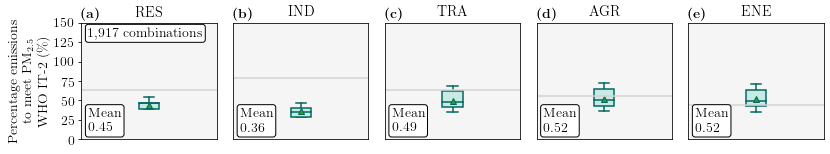

In [295]:
#for region in regions:
region = 'China'
fig = plt.figure(1, figsize=(15, 3))
gs = gridspec.GridSpec(1, 5)

# target = 'pm25_naqt'
# make_boxplot(0, factors_res[f'{region}_{target}'], 'RES', target_labels[target])
# make_boxplot(1, factors_ind[f'{region}_{target}'], 'IND', target_labels[target])
# make_boxplot(2, factors_tra[f'{region}_{target}'], 'TRA', target_labels[target])
# make_boxplot(3, factors_agr[f'{region}_{target}'], 'AGR', target_labels[target])
# make_boxplot(4, factors_ene[f'{region}_{target}'], 'ENE', target_labels[target])

target = 'pm25_who_it2'
make_boxplot(0, factors_res[f'{region}_{target}'], 'RES', target_labels[target])
make_boxplot(1, factors_ind[f'{region}_{target}'], 'IND', target_labels[target])
make_boxplot(2, factors_tra[f'{region}_{target}'], 'TRA', target_labels[target])
make_boxplot(3, factors_agr[f'{region}_{target}'], 'AGR', target_labels[target])
make_boxplot(4, factors_ene[f'{region}_{target}'], 'ENE', target_labels[target])

# target = 'pm25_who_it1'
# make_boxplot(10, factors_res[f'{region}_{target}'], 'RES', target_labels[target])
# make_boxplot(11, factors_ind[f'{region}_{target}'], 'IND', target_labels[target])
# make_boxplot(12, factors_tra[f'{region}_{target}'], 'TRA', target_labels[target])
# make_boxplot(13, factors_agr[f'{region}_{target}'], 'AGR', target_labels[target])
# make_boxplot(14, factors_ene[f'{region}_{target}'], 'ENE', target_labels[target])

# target = 'pm25_who_aqg'
# make_boxplot(15, factors_res[f'{region}_{target}'], 'RES', target_labels[target])
# make_boxplot(16, factors_ind[f'{region}_{target}'], 'IND', target_labels[target])
# make_boxplot(17, factors_tra[f'{region}_{target}'], 'TRA', target_labels[target])
# make_boxplot(18, factors_agr[f'{region}_{target}'], 'AGR', target_labels[target])
# make_boxplot(19, factors_ene[f'{region}_{target}'], 'ENE', target_labels[target])

# target = 'o3_counterfactual'
# make_boxplot(20, factors_res[f'{region}_{target}'], 'RES', target_labels[target])
# make_boxplot(21, factors_ind[f'{region}_{target}'], 'IND', target_labels[target])
# make_boxplot(22, factors_tra[f'{region}_{target}'], 'TRA', target_labels[target])
# make_boxplot(23, factors_agr[f'{region}_{target}'], 'AGR', target_labels[target])
# make_boxplot(24, factors_ene[f'{region}_{target}'], 'ENE', target_labels[target])

gs.tight_layout(fig, rect=[0, 0, 0.78, 0.78])

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/boxplots_emission_config_meet_targets_{region}_topdown2020baseline.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/boxplots_emission_config_meet_targets_{region}_topdown2020baseline.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [308]:
top_down_2020_baseline * 0.5

array([0.385, 0.29 , 0.345, 0.36 , 0.355])

In [309]:
ctl = 'RES0.770_IND0.580_TRA0.690_AGR0.720_ENE0.710'
sim = 'RES0.385_IND0.290_TRA0.690_AGR0.720_ENE0.710'

In [311]:
print(results_compare['China']['PM2_5_DRY']['exposure']['mean'][ctl])

33.42042530314885


In [310]:
print(results_compare['China']['PM2_5_DRY']['exposure']['mean'][sim])

23.837986520808677


In [312]:
diff_mean = (results_compare['China']['PM2_5_DRY']['mort']['mean'][ctl] ) \
            - (results_compare['China']['PM2_5_DRY']['mort']['mean'][sim] )
diff_lower = (results_compare['China']['PM2_5_DRY']['mort']['lower'][ctl] ) \
            - (results_compare['China']['PM2_5_DRY']['mort']['lower'][sim] )
diff_upper = (results_compare['China']['PM2_5_DRY']['mort']['upper'][ctl] ) \
            - (results_compare['China']['PM2_5_DRY']['mort']['upper'][sim] )
diff_per = int(100 * ((results_compare['China']['PM2_5_DRY']['mort']['mean'][sim] / results_compare['China']['PM2_5_DRY']['mort']['mean'][ctl]) - 1))
print(f'50% in RES and IND would further reduce the 2020 mort burden by {diff_per} % =  {int(round(diff_mean, -2)):,} (95UI: {int(round(diff_lower, -2)):,} - {int(round(diff_upper, -2)):,})')

50% in RES and IND would further reduce the 2020 mort burden by -18 % =  323,600 (95UI: 291,500 - 356,800)


In [313]:
diff_mean = (results_compare['China']['PM2_5_DRY']['mort']['mean'][ctl] +  results_compare['China']['o3_6mDM8h']['mort']['mean'][ctl]) \
            - (results_compare['China']['PM2_5_DRY']['mort']['mean'][sim] + results_compare['China']['o3_6mDM8h']['mort']['mean'][sim])
diff_lower = (results_compare['China']['PM2_5_DRY']['mort']['lower'][ctl] +  results_compare['China']['o3_6mDM8h']['mort']['lower'][ctl]) \
            - (results_compare['China']['PM2_5_DRY']['mort']['lower'][sim] + results_compare['China']['o3_6mDM8h']['mort']['lower'][sim])
diff_upper = (results_compare['China']['PM2_5_DRY']['mort']['upper'][ctl] +  results_compare['China']['o3_6mDM8h']['mort']['upper'][ctl]) \
            - (results_compare['China']['PM2_5_DRY']['mort']['upper'][sim] + results_compare['China']['o3_6mDM8h']['mort']['upper'][sim])
print(f'50% in RES and IND would further reduce the 2020 mort burden by {int(round(diff_mean, -2)):,} (95UI: {int(round(diff_lower, -2)):,} - {int(round(diff_upper, -2)):,})')

50% in RES and IND would further reduce the 2020 mort burden by 329,900 (95UI: 295,900 - 365,700)


### sector contribution to absolute pm2.5 concentrations
- bottom-up for 2010-2017  
- top-down for 2018-2020  
- use NO_SECTOR files  
- spatial maps  
- similar to figure 4 from liu et al., (2020)

In [53]:
results = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/results_compare_original_{matching_method}.joblib')
bottom_up = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/bottom_up_original_{matching_method}.joblib')
top_down = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/top_down_original_{matching_method}.joblib')

In [4]:
emission_configs = {
    'bottomup_2010_ctl':   'RES1.150_IND1.270_TRA0.980_AGR0.980_ENE1.360',
    'bottomup_2010_nores': 'RES0.000_IND1.270_TRA0.980_AGR0.980_ENE1.360',
    'bottomup_2010_noind': 'RES1.150_IND0.000_TRA0.980_AGR0.980_ENE1.360',
    'bottomup_2010_notra': 'RES1.150_IND1.270_TRA0.000_AGR0.980_ENE1.360',
    'bottomup_2010_noagr': 'RES1.150_IND1.270_TRA0.980_AGR0.000_ENE1.360',
    'bottomup_2010_noene': 'RES1.150_IND1.270_TRA0.980_AGR0.980_ENE0.000',
    
    'bottomup_2011_ctl':   'RES1.190_IND1.300_TRA1.010_AGR1.010_ENE1.460',
    'bottomup_2011_nores': 'RES0.000_IND1.300_TRA1.010_AGR1.010_ENE1.460',
    'bottomup_2011_noind': 'RES1.190_IND0.000_TRA1.010_AGR1.010_ENE1.460',
    'bottomup_2011_notra': 'RES1.190_IND1.300_TRA0.000_AGR1.010_ENE1.460',
    'bottomup_2011_noagr': 'RES1.190_IND1.300_TRA1.010_AGR0.000_ENE1.460',
    'bottomup_2011_noene': 'RES1.190_IND1.300_TRA1.010_AGR1.010_ENE0.000',
    
    'bottomup_2012_ctl':   'RES1.200_IND1.300_TRA1.010_AGR1.020_ENE1.390',
    'bottomup_2012_nores': 'RES0.000_IND1.300_TRA1.010_AGR1.020_ENE1.390',
    'bottomup_2012_noind': 'RES1.200_IND0.000_TRA1.010_AGR1.020_ENE1.390',
    'bottomup_2012_notra': 'RES1.200_IND1.300_TRA0.000_AGR1.020_ENE1.390',
    'bottomup_2012_noagr': 'RES1.200_IND1.300_TRA1.010_AGR0.000_ENE1.390',
    'bottomup_2012_noene': 'RES1.200_IND1.300_TRA1.010_AGR1.020_ENE0.000',
    
    'bottomup_2013_ctl':   'RES1.130_IND1.290_TRA1.020_AGR1.010_ENE1.290',
    'bottomup_2013_nores': 'RES0.000_IND1.290_TRA1.020_AGR1.010_ENE1.290',
    'bottomup_2013_noind': 'RES1.130_IND0.000_TRA1.020_AGR1.010_ENE1.290',
    'bottomup_2013_notra': 'RES1.130_IND1.290_TRA0.000_AGR1.010_ENE1.290',
    'bottomup_2013_noagr': 'RES1.130_IND1.290_TRA1.020_AGR0.000_ENE1.290',
    'bottomup_2013_noene': 'RES1.130_IND1.290_TRA1.020_AGR1.010_ENE0.000',
    
    'bottomup_2014_ctl':   'RES1.060_IND1.120_TRA0.990_AGR1.010_ENE1.120',
    'bottomup_2014_nores': 'RES0.000_IND1.120_TRA0.990_AGR1.010_ENE1.120',
    'bottomup_2014_noind': 'RES1.060_IND0.000_TRA0.990_AGR1.010_ENE1.120',
    'bottomup_2014_notra': 'RES1.060_IND1.120_TRA0.000_AGR1.010_ENE1.120',
    'bottomup_2014_noagr': 'RES1.060_IND1.120_TRA0.990_AGR0.000_ENE1.120',
    'bottomup_2014_noene': 'RES1.060_IND1.120_TRA0.990_AGR1.010_ENE0.000',
    
    'bottomup_2015_ctl':   'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
    'bottomup_2015_nores': 'RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
    'bottomup_2015_noind': 'RES1.0_IND0.0_TRA1.0_AGR1.0_ENE1.0',
    'bottomup_2015_notra': 'RES1.0_IND1.0_TRA0.0_AGR1.0_ENE1.0',
    'bottomup_2015_noagr': 'RES1.0_IND1.0_TRA1.0_AGR0.0_ENE1.0',
    'bottomup_2015_noene': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE0.0',
    
    'bottomup_2016_ctl':   'RES0.920_IND0.840_TRA0.970_AGR0.990_ENE0.940',
    'bottomup_2016_nores': 'RES0.000_IND0.840_TRA0.970_AGR0.990_ENE0.940',
    'bottomup_2016_noind': 'RES0.920_IND0.000_TRA0.970_AGR0.990_ENE0.940',
    'bottomup_2016_notra': 'RES0.920_IND0.840_TRA0.000_AGR0.990_ENE0.940',
    'bottomup_2016_noagr': 'RES0.920_IND0.840_TRA0.970_AGR0.000_ENE0.940',
    'bottomup_2016_noene': 'RES0.920_IND0.840_TRA0.970_AGR0.990_ENE0.000',
    
    'bottomup_2017_ctl':   'RES0.840_IND0.810_TRA0.990_AGR0.990_ENE0.890',
    'bottomup_2017_nores': 'RES0.000_IND0.810_TRA0.990_AGR0.990_ENE0.890',
    'bottomup_2017_noind': 'RES0.840_IND0.000_TRA0.990_AGR0.990_ENE0.890',
    'bottomup_2017_notra': 'RES0.840_IND0.810_TRA0.000_AGR0.990_ENE0.890',
    'bottomup_2017_noagr': 'RES0.840_IND0.810_TRA0.990_AGR0.000_ENE0.890',
    'bottomup_2017_noene': 'RES0.840_IND0.810_TRA0.990_AGR0.990_ENE0.000',
    
    'topdown_2018_ctl':   'RES0.820_IND0.850_TRA0.720_AGR0.810_ENE0.730',
    'topdown_2018_nores': 'RES0.000_IND0.850_TRA0.720_AGR0.810_ENE0.730',
    'topdown_2018_noind': 'RES0.820_IND0.000_TRA0.720_AGR0.810_ENE0.730',
    'topdown_2018_notra': 'RES0.820_IND0.850_TRA0.000_AGR0.810_ENE0.730',
    'topdown_2018_noagr': 'RES0.820_IND0.850_TRA0.720_AGR0.000_ENE0.730',
    'topdown_2018_noene': 'RES0.820_IND0.850_TRA0.720_AGR0.810_ENE0.000',
    
    'topdown_2019_ctl':   'RES0.820_IND0.780_TRA0.750_AGR0.830_ENE0.720',
    'topdown_2019_nores': 'RES0.000_IND0.780_TRA0.750_AGR0.830_ENE0.720',
    'topdown_2019_noind': 'RES0.820_IND0.000_TRA0.750_AGR0.830_ENE0.720',
    'topdown_2019_notra': 'RES0.820_IND0.780_TRA0.000_AGR0.830_ENE0.720',
    'topdown_2019_noagr': 'RES0.820_IND0.780_TRA0.750_AGR0.000_ENE0.720',
    'topdown_2019_noene': 'RES0.820_IND0.780_TRA0.750_AGR0.830_ENE0.000',
    
    'topdown_2020_ctl':   'RES0.770_IND0.580_TRA0.690_AGR0.720_ENE0.710',
    'topdown_2020_nores': 'RES0.000_IND0.580_TRA0.690_AGR0.720_ENE0.710',
    'topdown_2020_noind': 'RES0.770_IND0.000_TRA0.690_AGR0.720_ENE0.710',
    'topdown_2020_notra': 'RES0.770_IND0.580_TRA0.000_AGR0.720_ENE0.710',
    'topdown_2020_noagr': 'RES0.770_IND0.580_TRA0.690_AGR0.000_ENE0.710',
    'topdown_2020_noene': 'RES0.770_IND0.580_TRA0.690_AGR0.720_ENE0.000',
}

In [5]:
results_compare = {}
outcomes_keys_compare = {
    'exposure_PM2_5_DRY_mean': 'pm25_popweighted',
    'exposure_o3_6mDM8h_mean': 'o3_popweighted',
    'mort_PM2_5_DRY_mean': 'mort_ncdlri_mean_total',
    'mort_o3_6mDM8h_mean': 'mort_copd_mean_total',
    'mort_PM2_5_DRY_lower': 'mort_ncdlri_lower_total',
    'mort_o3_6mDM8h_lower': 'mort_copd_lower_total',
    'mort_PM2_5_DRY_upper': 'mort_ncdlri_upper_total',
    'mort_o3_6mDM8h_upper': 'mort_copd_upper_total',
    'dalys_rate_PM2_5_DRY_mean': 'dalys_rate_ncdlri_mean_total',
    'dalys_rate_o3_6mDM8h_mean': 'dalys_rate_copd_mean_total',
    'dalys_rate_PM2_5_DRY_lower': 'dalys_rate_ncdlri_lower_total',
    'dalys_rate_o3_6mDM8h_lower': 'dalys_rate_copd_lower_total',
    'dalys_rate_PM2_5_DRY_upper': 'dalys_rate_ncdlri_upper_total',
    'dalys_rate_o3_6mDM8h_upper': 'dalys_rate_copd_upper_total',
}

for region in regions_all:
    results_compare.update({region: {}})
    for output in outputs:
        results_compare[region].update({output: {}})
        for outcome in ['exposure', 'mort', 'dalys_rate']:
            results_compare[region][output].update({outcome: {}})
            for metric in ['mean', 'lower', 'upper']:
                results_compare[region][output][outcome].update({metric: {}})

In [6]:
for emission_config_key, emission_config_value in emission_configs.items():
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        df_country = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_country_hia_{output}_{emission_config_value}_adjusted_scaled.csv')
        df_province = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_province_hia_{output}_{emission_config_value}_adjusted_scaled.csv')
        df_prefecture = pd.read_csv(f'{path_hia}/{output}_adjusted_scaled/df_prefecture_hia_{output}_{emission_config_value}_adjusted_scaled.csv')

        for region in regions_all:
            for outcome in ['exposure', 'mort', 'dalys_rate']:
                for metric in ['mean', 'lower', 'upper']:
                    if outcome == 'exposure' and metric != 'mean':
                        continue
                    if region == 'China':
                        result = df_country.loc[df_country.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                    if outcome == 'mort': # sum number of mortalities over regions
                        if region == 'GBA':
                            result = df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                        if region in regions.keys():
                            result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                    if outcome == 'dalys_rate' or outcome  == 'exposure': # find the mean over the regions for dalys rate and exposure
                        if region == 'GBA':
                            values = np.concatenate((df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values), axis=0)
                            values[values == 0.0] = np.nan
                            result = np.nanmean(values)
                        if region in regions.keys():
                            values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values
                            values[values == 0.0] = np.nan
                            result = np.nanmean(values)


                    results_compare[region][output][outcome][metric].update({f'{emission_config_key}': result})

In [66]:
results = results_compare['China']['PM2_5_DRY']['exposure']['mean']

In [8]:
results_compare_spatialmaps = {}
path_exposures = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions'
for emission_config_key, emission_config_value in emission_configs.items():
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        with xr.open_dataset(f'{path_exposures}/{output}_adjusted_scaled/ds_{emission_config_value}_{output}_popgrid_0.25deg_adjusted_scaled.nc') as ds:
            results_compare_spatialmaps.update({f'{emission_config_key}_{output}': ds[output]})

In [9]:
ctl = results_compare_spatialmaps['bottomup_2010_ctl_PM2_5_DRY']
lat = ctl.lat.values
lon = ctl.lon.values
xx, yy = np.meshgrid(lon, lat)

In [10]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

In [71]:
def make_spatial_plot(index, ds, output, levels, title, show_color_bar, cmap, extend):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
    shape_feature = ShapelyFeature(
        Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                             
        ccrs.PlateCarree(), 
        facecolor='none'
    )
    ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    ax.patch.set_visible(False)
    ax.spines['geo'].set_visible(False)
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    im = ax.contourf(xx, yy, ds, levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend=extend)
    if show_color_bar:
        cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels, shrink=0.47)
        cb.set_label('Annual-mean PM$_{2.5}$\nconcentrations (${\mu}g$ $m^{-3}$)', size=14)
        cb.ax.tick_params(labelsize=14)

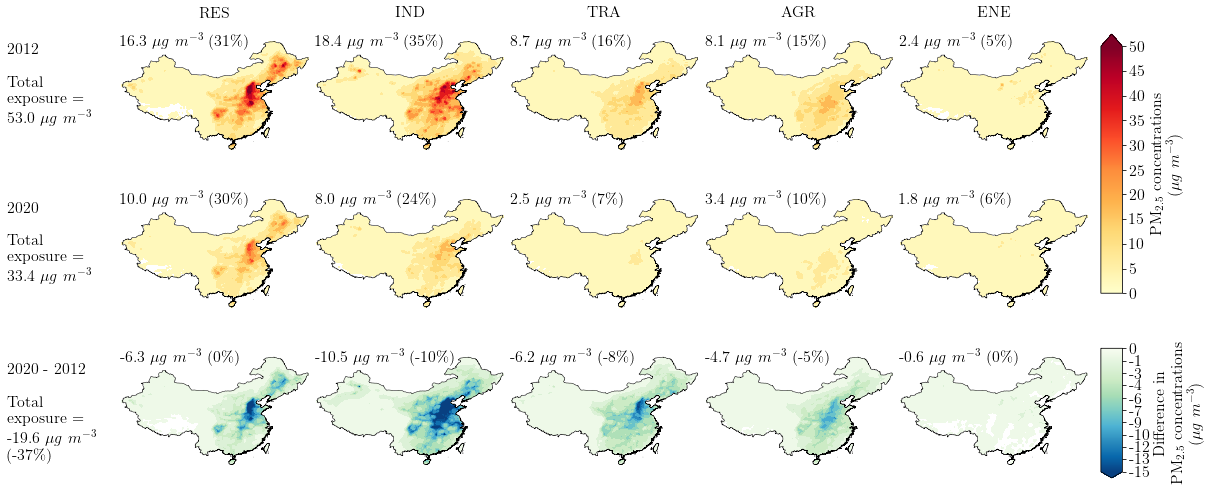

In [72]:
fig = plt.figure(1, figsize=(15, 9))
gs = gridspec.GridSpec(3, 5)

output = 'PM2_5_DRY'
sims = ['nores', 'noind', 'notra', 'noagr', 'noene']
sim_titles = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
subplot_label = 0

for year in ['2012', '2020']:
    if year == '2012':
        matched_to = 'bottomup'
    elif year == '2020':
        matched_to = 'topdown'
        
    for index, sim in enumerate(sims):
        make_spatial_plot(subplot_label, results_compare_spatialmaps[f'{matched_to}_{year}_ctl_{output}'] - \
            results_compare_spatialmaps[f'{matched_to}_{year}_{sim}_{output}'], output,
            np.linspace(0.0001, 50, 11), f'{year} {sim_titles[index]}', False, 'YlOrRd', 'max')
        if year == '2012':
            plt.title(f'{sim_titles[index]}\n', fontsize=16)
        if index == 0:
            plt.annotate(f"{year}\n\nTotal\nexposure = \n{results[f'{matched_to}_{year}_ctl']:.1f}" + ' ${\mu}g$ $m^{-3}$',
                         xy=(-0.6, 0.25), xycoords='axes fraction', fontsize=16)

        contribution_abs = results[f'{matched_to}_{year}_ctl'] - results[f'{matched_to}_{year}_{sim}']
        contribution_per = 100 * contribution_abs / results[f'{matched_to}_{year}_ctl']
        plt.annotate(f'{contribution_abs:.1f}' + ' ${\mu}g$ $m^{-3}$' + f' ({contribution_per:0.0f}\%)',
                     xy=(0.0, 0.95), xycoords='axes fraction', fontsize=16)
        subplot_label += 1
        
# diff
for index, sim in enumerate(sims):
    diff = (results_compare_spatialmaps[f'topdown_2020_ctl_{output}'] - \
               results_compare_spatialmaps[f'topdown_2020_{sim}_{output}']) - \
           (results_compare_spatialmaps[f'bottomup_2012_ctl_{output}'] - \
               results_compare_spatialmaps[f'bottomup_2012_{sim}_{output}'])
    make_spatial_plot(subplot_label, diff, output, np.linspace(-15, -0.0001, 11),
                      f'{year} {sim_titles[index]}', False, 'GnBu_r', 'min')
    if index == 0:
        reduction_total_abs = results[f'topdown_2020_ctl'] - results[f'bottomup_2012_ctl']
        reduction_total_per = 100 * reduction_total_abs / results[f'bottomup_2012_ctl']
        plt.annotate(f"2020 - 2012\n\nTotal\nexposure = \n{reduction_total_abs:.1f}" + \
                     ' ${\mu}g$ $m^{-3}$\n' + f'({reduction_total_per:.0f}\%)',
                     xy=(-0.6, 0.05), xycoords='axes fraction', fontsize=16)

    contribution_abs = (results[f'topdown_2020_ctl'] - results[f'topdown_2020_{sim}']) - \
                       (results[f'bottomup_2012_ctl'] - results[f'bottomup_2012_{sim}'])
    contribution_per = (100 * (results[f'topdown_2020_ctl'] - results[f'topdown_2020_{sim}']) / \
                        results[f'topdown_2020_ctl']) - \
                       (100 * (results[f'bottomup_2012_ctl'] - results[f'bottomup_2012_{sim}']) / \
                        results[f'bottomup_2012_ctl']) 
    #contribution_per = 100 * contribution_abs / reduction_total_abs
    plt.annotate(f'{contribution_abs:.1f}' + ' ${\mu}g$ $m^{-3}$' + f' ({int(contribution_per)}\%)',
                 xy=(0.0, 0.95), xycoords='axes fraction', fontsize=16)
    subplot_label += 1

gs.tight_layout(fig, h_pad=-8.5, w_pad=0.5)

ax_cbar = fig.add_axes([1.0, 0.435, 0.02, 0.4])
levels = np.linspace(0.0001, 50, 11)
sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1]), cmap='YlOrRd')
sm.set_array([])  
cb = plt.colorbar(sm, cax=ax_cbar, norm=matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1]),
                  cmap='YlOrRd', ticks=levels, extend='max')
ticks = [str(format(int(item), ',')) for item in levels]
cb.ax.set_yticklabels(ticks)
cb.set_label('PM$_{2.5}$ concentrations\n(${\mu}g$ $m^{-3}$)', size=16)
cb.ax.tick_params(labelsize=16)

ax_cbar = fig.add_axes([1.0, 0.15, 0.02, 0.2])
levels = np.linspace(-15, -0.0001, 11)
sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1]), cmap='GnBu_r')
sm.set_array([])  
cb = plt.colorbar(sm, cax=ax_cbar, norm=matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1]),
                  cmap='GnBu_r', ticks=levels, extend='min')
ticks = [str(format(int(item), ',')) for item in levels]
cb.ax.set_yticklabels(ticks)
cb.set_label('Difference in\nPM$_{2.5}$ concentrations\n(${\mu}g$ $m^{-3}$)', size=16)
cb.ax.tick_params(labelsize=16)

plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/sector_contributions_to_abs_exposure_{output}_2012-2020-only.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/sector_contributions_to_abs_exposure_{output}_2012-2020-only.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

### sector contributions to improvements in pm2.5 exposure and health impacts
- bottom-up for 2010-2017  
- top-down for 2018-2020  
- also use NO_SECTOR only files  
- bar plots  
- similar to figure 5 from liu et al (2020)

In [8]:
sims = ['nores', 'noind', 'notra', 'noagr', 'noene']
region = 'China'
output = 'PM2_5_DRY'

ctl_mort_2012 = results_compare[region][output]['mort']['mean'][f'bottomup_2012_ctl']
ctl_mort_2020 = results_compare[region][output]['mort']['mean'][f'topdown_2020_ctl']
ctl_mort_2012_lower = results_compare[region][output]['mort']['lower'][f'bottomup_2012_ctl']
ctl_mort_2020_lower = results_compare[region][output]['mort']['lower'][f'topdown_2020_ctl']
ctl_mort_2012_upper = results_compare[region][output]['mort']['upper'][f'bottomup_2012_ctl']
ctl_mort_2020_upper = results_compare[region][output]['mort']['upper'][f'topdown_2020_ctl']
diff_ctl_mort_abs = ctl_mort_2020 - ctl_mort_2012
diff_ctl_mort_per = 100 * diff_ctl_mort_abs / ctl_mort_2012

print('attribution mort')
print(f'2012      {int(round(ctl_mort_2012, -2)):,}')
print(f'2020      {int(round(ctl_mort_2020, -2)):,}')
print(f'2020-2012  {int(round(diff_ctl_mort_abs, -2)):,}', f'{diff_ctl_mort_per:.0f}%')
print()

for sim in sims:
    ctl_exposure_2012 = results_compare[region][output]['exposure']['mean'][f'bottomup_2012_ctl']
    var_exposure_2012 = results_compare[region][output]['exposure']['mean'][f'bottomup_2012_{sim}']
    diff_exposure_2012 = ctl_exposure_2012 - var_exposure_2012
    diff_mort_2012 = (diff_exposure_2012 / ctl_exposure_2012) * ctl_mort_2012
    
    ctl_exposure_2020 = results_compare[region][output]['exposure']['mean'][f'topdown_2020_ctl']
    var_exposure_2020 = results_compare[region][output]['exposure']['mean'][f'topdown_2020_{sim}']
    diff_exposure_2020 = ctl_exposure_2020 - var_exposure_2020
    diff_mort_2020 = (diff_exposure_2020 / ctl_exposure_2020) * ctl_mort_2020

    diff_mort_abs = diff_mort_2020 - diff_mort_2012
    diff_mort_per = 100 * diff_mort_abs / diff_ctl_mort_abs
    
    print(sim[-3:], round(diff_exposure_2012, 1), round(diff_exposure_2020, 1), 
          round(diff_exposure_2020 - diff_exposure_2012, 1),
          f'{int(round(diff_mort_2012, -2)):,}', f'{int(round(diff_mort_2020, -2)):,}', 
          f'{int(round(diff_mort_2020 - diff_mort_2012, -2)):,}', 
          f'{int(round(diff_mort_abs, -2)):,}', f'{diff_mort_per:.0f}%')
    
print()
print('subtraction mort')
for sim in sims:
    diff_mort_2012_mean = results_compare[region][output]['mort']['mean'][f'bottomup_2012_{sim}'] - ctl_mort_2012
    diff_mort_2020_mean = results_compare[region][output]['mort']['mean'][f'topdown_2020_{sim}'] - ctl_mort_2020
    diff_mort_2012_lower = results_compare[region][output]['mort']['lower'][f'bottomup_2012_{sim}'] - ctl_mort_2012_lower
    diff_mort_2020_lower = results_compare[region][output]['mort']['lower'][f'topdown_2020_{sim}'] - ctl_mort_2020_lower
    diff_mort_2012_upper = results_compare[region][output]['mort']['upper'][f'bottomup_2012_{sim}'] - ctl_mort_2012_upper
    diff_mort_2020_upper = results_compare[region][output]['mort']['upper'][f'topdown_2020_{sim}'] - ctl_mort_2020_upper

    diff_mort_abs_mean = diff_mort_2020_mean - diff_mort_2012_mean
    diff_mort_abs_lower = diff_mort_2020_lower - diff_mort_2012_lower
    diff_mort_abs_upper = diff_mort_2020_upper - diff_mort_2012_upper
    diff_mort_per = 100 * diff_mort_abs_mean / diff_ctl_mort_abs
    
    print(sim[-3:], 
          f'{int(round(diff_mort_2012_mean, -2)):,}', f'{int(round(diff_mort_2020_mean, -2)):,}', 
          f'{int(round(diff_mort_abs_mean, -2)):,} (95UI: {int(round(diff_mort_abs_lower, -2)):,} - {int(round(diff_mort_abs_upper, -2)):,})',
          f'{diff_mort_per:.0f}%')

attribution mort
2012      2,273,400
2020      1,751,700
2020-2012  -521,700 -23%

res 16.3 10.0 -6.3 698,500 523,800 -174,600 -174,600 33%
ind 18.4 8.0 -10.5 789,700 416,800 -372,800 -372,800 71%
tra 8.7 2.5 -6.2 374,100 130,800 -243,300 -243,300 47%
agr 8.1 3.4 -4.7 348,500 179,600 -169,000 -169,000 32%
ene 2.4 1.8 -0.6 104,800 96,600 -8,100 -8,100 2%

subtraction mort
res -417,400 -339,000 78,500 (95UI: 73,600 - 83,000) -15%
ind -487,500 -266,900 220,600 (95UI: 201,600 - 239,700) -42%
tra -215,100 -80,600 134,500 (95UI: 122,700 - 146,500) -26%
agr -206,300 -115,900 90,400 (95UI: 82,900 - 98,000) -17%
ene -56,300 -59,200 -2,900 (95UI: -2,200 - -3,700) 1%


In [14]:
print('comparison to liu 2020')

region = 'China'
output = 'PM2_5_DRY'

ctl_mort_2010 = results_compare[region][output]['mort']['mean'][f'bottomup_2010_ctl']
ctl_mort_2015 = results_compare[region][output]['mort']['mean'][f'bottomup_2015_ctl']
ctl_mort_2010_lower = results_compare[region][output]['mort']['lower'][f'bottomup_2010_ctl']
ctl_mort_2015_lower = results_compare[region][output]['mort']['lower'][f'bottomup_2015_ctl']
ctl_mort_2010_upper = results_compare[region][output]['mort']['upper'][f'bottomup_2010_ctl']
ctl_mort_2015_upper = results_compare[region][output]['mort']['upper'][f'bottomup_2015_ctl']
diff_ctl_mort_abs = ctl_mort_2015 - ctl_mort_2010
diff_ctl_mort_per = 100 * diff_ctl_mort_abs / ctl_mort_2010

print('attribution mort')
print(f'2010      {int(round(ctl_mort_2010, -2)):,}')
print(f'2015      {int(round(ctl_mort_2015, -2)):,}')
print(f'2015-2010  {int(round(diff_ctl_mort_abs, -2)):,}', f'{diff_ctl_mort_per:.0f}%')
print()

for sim in sims:
    ctl_exposure_2010 = results_compare[region][output]['exposure']['mean'][f'bottomup_2010_ctl']
    var_exposure_2010 = results_compare[region][output]['exposure']['mean'][f'bottomup_2010_{sim}']
    diff_exposure_2010 = ctl_exposure_2010 - var_exposure_2010
    diff_mort_2010 = (diff_exposure_2010 / ctl_exposure_2010) * ctl_mort_2010
    diff_mort_2010_lower = (diff_exposure_2010 / ctl_exposure_2010) * ctl_mort_2010_lower
    diff_mort_2010_upper = (diff_exposure_2010 / ctl_exposure_2010) * ctl_mort_2010_upper
    
    ctl_exposure_2015 = results_compare[region][output]['exposure']['mean'][f'bottomup_2015_ctl']
    var_exposure_2015 = results_compare[region][output]['exposure']['mean'][f'bottomup_2015_{sim}']
    diff_exposure_2015 = ctl_exposure_2015 - var_exposure_2015
    diff_mort_2015 = (diff_exposure_2015 / ctl_exposure_2015) * ctl_mort_2015
    diff_mort_2015_lower = (diff_exposure_2015 / ctl_exposure_2015) * ctl_mort_2015_lower
    diff_mort_2015_upper = (diff_exposure_2015 / ctl_exposure_2015) * ctl_mort_2015_upper

    diff_mort_abs = diff_mort_2015 - diff_mort_2010
    diff_mort_abs_lower = diff_mort_2015_lower - diff_mort_2010_lower
    diff_mort_abs_upper = diff_mort_2015_upper - diff_mort_2010_upper
    diff_mort_per = 100 * diff_mort_abs / diff_ctl_mort_abs
    
    print(sim[-3:], 
          round(diff_exposure_2010, 1), f'{100 * diff_exposure_2010 / ctl_exposure_2010:.0f}%',
          round(diff_exposure_2015, 1), f'{100 * diff_exposure_2015 / ctl_exposure_2015:.0f}%',
          round(diff_exposure_2015 - diff_exposure_2010, 1),
          f'{int(round(diff_mort_2010, -2)):,}', f'{int(round(diff_mort_2015, -2)):,}', 
          f'{int(round(diff_mort_abs, -2)):,}',
          f'{int(round(diff_mort_abs_lower, -2)):,}',
          f'{int(round(diff_mort_abs_upper, -2)):,}',
          f'{diff_mort_per:.0f}%')

comparison to liu 2020
attribution mort
2010      2,253,500
2015      2,149,000
2015-2010  -104,500 -5%

res 16.0 31% 14.8 31% -1.2 691,700 668,200 -23,500 -21,500 -25,500 22%
ind 18.2 35% 15.7 33% -2.5 786,400 706,200 -80,300 -72,300 -88,500 77%
tra 8.2 16% 6.4 13% -1.8 354,700 288,500 -66,200 -59,500 -73,300 63%
agr 8.1 15% 7.9 17% -0.1 348,300 356,500 8,100 7,000 9,400 -8%
ene 2.8 5% 3.3 7% 0.6 119,700 150,700 31,100 27,700 34,600 -30%


In [714]:
years = np.arange(2010, 2021)
sector_colors = {'RES': '#1b9e77', 'IND': '#d95f02', 'TRA': '#7570b3', 'AGR': '#66a61e', 'ENE': '#e6ab02'}

def make_sector_plot(index, letter, results_compare, region, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + letter + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.get_major_locator().set_params(integer=True)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    plt.xlim([2009, 2021])
    
    for year in years:
        if year <= 2017:
            matched_to = 'bottomup'
        else:
            matched_to = 'topdown'
            
        running_total = 0
        for sim in sims:
            ctl = results_compare[region][output][outcome]['mean'][f'{matched_to}_{year}_ctl']
            var = results_compare[region][output][outcome]['mean'][f'{matched_to}_{year}_{sim}']
            diff = ctl - var
            plt.bar(year, diff, bottom=running_total, color=sector_colors[sim[-3:].upper()], zorder=1)
            running_total += diff
            if running_total < ctl:
                plt.bar(year, ctl - running_total, bottom=running_total, color='lightgrey', zorder=1)
            if sim == 'noene':
                if outcome == 'mort':
                    lower = results_compare[region][output][outcome]['lower'][f'{matched_to}_{year}_ctl']
                    upper = results_compare[region][output][outcome]['upper'][f'{matched_to}_{year}_ctl']
                    plt.vlines(year, lower, upper, color='grey', zorder=2)
                

In [15]:
years = np.arange(2010, 2021)
sector_colors = {'RES': '#1b9e77', 'IND': '#d95f02', 'TRA': '#7570b3', 'AGR': '#66a61e', 'ENE': '#e6ab02'}

def make_sector_plot(index, letter, results_compare, region, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + letter + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.get_major_locator().set_params(integer=True)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    plt.xlim([2009, 2021])
    
    for year in years:
        if year <= 2017:
            matched_to = 'bottomup'
        else:
            matched_to = 'topdown'
            
        running_total_exposure = 0
        running_total_mort = 0
        for sim in sims:
            ctl_exposure = results_compare[region][output]['exposure']['mean'][f'{matched_to}_{year}_ctl']
            var_exposure = results_compare[region][output]['exposure']['mean'][f'{matched_to}_{year}_{sim}']
            diff_exposure = ctl_exposure - var_exposure
            if outcome == 'mort':
                ctl_mort = results_compare[region][output]['mort']['mean'][f'{matched_to}_{year}_ctl']
                diff_mort = (diff_exposure / ctl_exposure) * ctl_mort
                plt.bar(year, diff_mort, bottom=running_total_mort,
                        color=sector_colors[sim[-3:].upper()], zorder=1)
                running_total_mort += diff_mort
                
                if running_total_mort < ctl_mort:
                    plt.bar(year, results_compare[region][output]['mort']['mean'][f'{matched_to}_{year}_ctl'] - \
                            running_total_mort, bottom=running_total_mort, color='lightgrey', zorder=1)
            else:
                plt.bar(year, diff_exposure, bottom=running_total_exposure,
                        color=sector_colors[sim[-3:].upper()], zorder=1)
                running_total_exposure += diff_exposure
                
                if running_total_exposure < ctl_exposure:
                    plt.bar(year, ctl_exposure - running_total_exposure, bottom=running_total_exposure,
                            color='lightgrey', zorder=1)
                        
            if sim == 'noene' and outcome == 'mort':
                lower = results_compare[region][output]['mort']['lower'][f'{matched_to}_{year}_ctl']
                upper = results_compare[region][output]['mort']['upper'][f'{matched_to}_{year}_ctl']
                plt.vlines(year, lower, upper, color='grey', zorder=4)
                

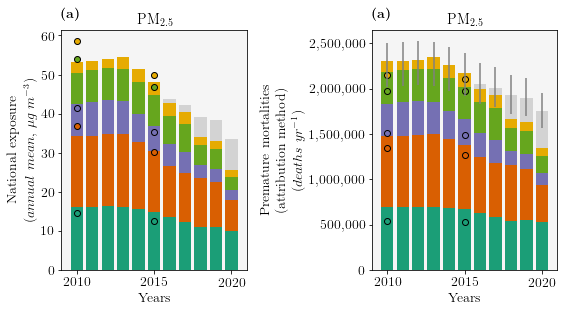

In [18]:
fig = plt.figure(1, figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

make_sector_plot(0, 'a', results_compare, 'China', 'PM2_5_DRY', 'exposure', 'National exposure\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
plt.scatter(2010, 14.7, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1+4.6, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1+4.6+12.6, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1+4.6+12.6+4.6, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5+5.2, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5+5.2+11.6, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5+5.2+11.6+3.0, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')

make_sector_plot(1, 'a', results_compare, 'China', 'PM2_5_DRY', 'mort', 'Premature mortalities\n(attribution method)\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
plt.scatter(2010, 543_400, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700+168_200, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700+168_200+459_000, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700+168_200+459_000+177_600, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000+218_300, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000+218_300+484_400, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000+218_300+484_400+130_900, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')

plt.tight_layout()
plt.show()

In [37]:
def make_plot(index, letter, bottom_up, top_down, regions, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + letter + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.get_major_locator().set_params(integer=True)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    plt.xlim([2010, 2020])
    for region in regions:
        if region == 'China':
            plt.plot(years, bottom_up[f'{region}_{output}_{outcome}_mean'], color=paper_colors['Bottom-up'], marker='o', label='Bottom-up')
            plt.plot(years, top_down[f'{region}_{output}_{outcome}_mean'], color=paper_colors['Top-down'], marker='o', label='Top-down')
        else:
            plt.plot(years, bottom_up[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o')
            plt.plot(years, top_down[f'{region}_{output}_{outcome}_mean'], color=region_colors[region], marker='o', alpha=0.5)
        if outcome != 'exposure':
            if region == 'China':
                plt.fill_between(years, bottom_up[f'{region}_{output}_{outcome}_lower'], bottom_up[f'{region}_{output}_{outcome}_upper'], facecolor=paper_colors['Bottom-up'], alpha=0.5)
                plt.fill_between(years, top_down[f'{region}_{output}_{outcome}_lower'], top_down[f'{region}_{output}_{outcome}_upper'], facecolor=paper_colors['Top-down'], alpha=0.5)
            else:
                plt.fill_between(years, bottom_up[f'{region}_{output}_{outcome}_lower'], bottom_up[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.5)
                plt.fill_between(years, top_down[f'{region}_{output}_{outcome}_lower'], top_down[f'{region}_{output}_{outcome}_upper'], facecolor=region_colors[region], alpha=0.2)

In [43]:
yue_2020_pm25_exposure = np.array([52.0, 49.5, 47.0, 52.5, 52.0, 48.5, 45.0, 42.2, np.nan, np.nan, np.nan])
yue_2020_pm25_mort = np.array([900_000, 900_000, 880_000, 931_000, 980_000, 990_000, 980_000, 971_000, np.nan, np.nan, np.nan])

In [44]:
paper_colors = {
    'Observations': '#a6cee3',
    'Bottom-up': '#1f78b4',
    'Top-down': '#b2df8a',
    'HEI (2020)': '#33a02c',
    'GBD2019 (2020)': '#b15928',
    'Silver et al., (2020)': '#e31a1c',
    'Zhang et al., (2019)': '#fdbf6f',
    'Liang et al., (2020)': '#ff7f00',
    'Huang et al., (2021)': '#cab2d6',
    'Dang and Liao, (2019)': '#6a3d9a',
    'Ding et al., (2019)': '#ffff99',
    'Yue et al., (2020)': '#fb9a99',
}
paper_legends = []
for label, color in paper_colors.items():
    paper_legend = matplotlib.lines.Line2D([], [], color=color, marker='o', linewidth=1.0, label=label)
    paper_legends.append(paper_legend)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

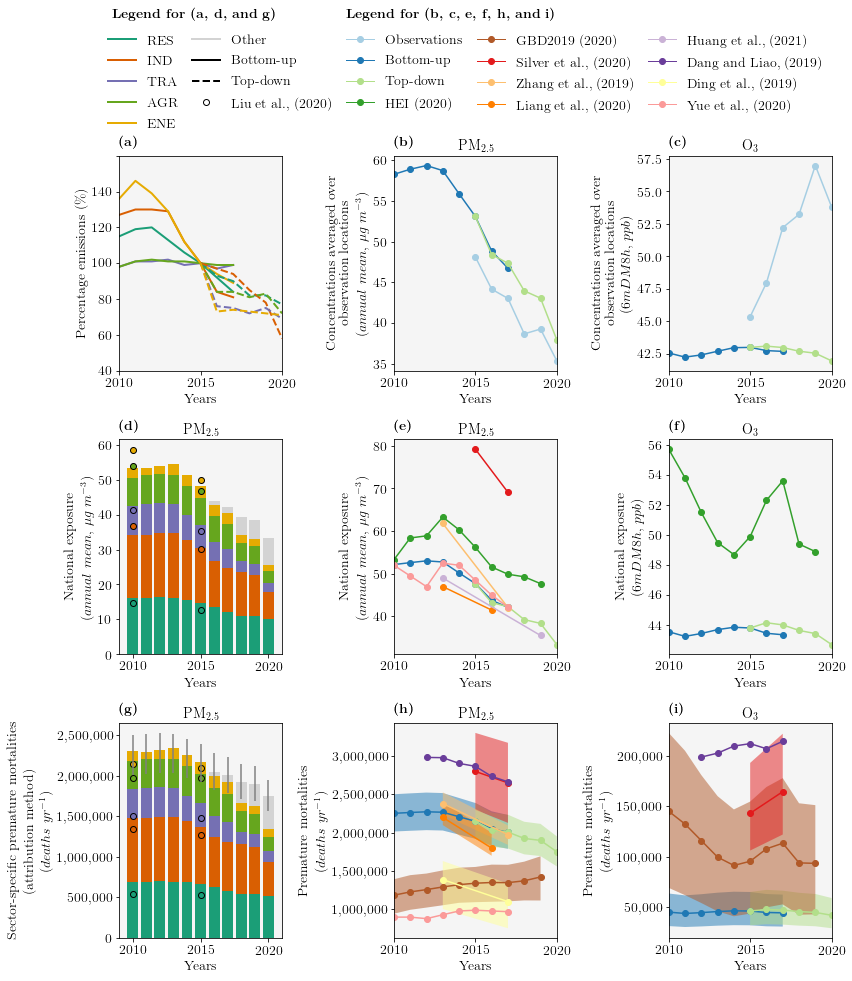

In [49]:
fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax = fig.add_subplot(gs[0])
plt.annotate(r'\textbf{(a)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlim([2010, 2020])
plt.ylim([0.4, 1.5])
plt.yticks(np.arange(0.4, 1.60, 0.20))
ax.set_yticklabels(np.arange(40, 160, 20))
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage emissions ({\%})', fontsize=14)
plt.plot(bottom_up_years, bottom_up_res, color='#1b9e77', label='RES', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_ind, color='#d95f02', label='IND', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_tra, color='#7570b3', label='TRA', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_agr, color='#66a61e', label='AGR', linewidth=2.0)
plt.plot(bottom_up_years, bottom_up_ene, color='#e6ab02', label='ENE', linewidth=2.0)
plt.plot(top_down_years, top_down_res, color='#1b9e77', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_ind, color='#d95f02', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_tra, color='#7570b3', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_agr, color='#66a61e', linestyle='dashed', linewidth=2.0)
plt.plot(top_down_years, top_down_ene, color='#e6ab02', linestyle='dashed', linewidth=2.0)

ax = fig.add_subplot(gs[1])
plt.annotate(r'\textbf{(b)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xlim([2010, 2020])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Concentrations averaged over\nobservation locations\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', fontsize=14)
plt.title('PM$_{2.5}$')
plt.plot(obs_years, obs_PM2_5_DRY, color=paper_colors['Observations'], marker='o', label='Observations')
plt.plot(bottom_up_years, bottom_up_PM2_5_DRY, color=paper_colors['Bottom-up'], marker='o', label='Bottom-up')
plt.plot(top_down_years, top_down_PM2_5_DRY, color=paper_colors['Top-down'], marker='o', label='Top-down')

ax = fig.add_subplot(gs[2])
plt.annotate(r'\textbf{(c)}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.xlim([2010, 2020])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Concentrations averaged over\nobservation locations\n($6mDM8h,$ $ppb$)', fontsize=14)
plt.title('O$_{3}$')
plt.plot(obs_years, obs_o3_6mDM8h, color=paper_colors['Observations'], marker='o', label='Observations')
plt.plot(bottom_up_years, bottom_up_o3_6mDM8h, color=paper_colors['Bottom-up'], marker='o', label='Bottom-up')
plt.plot(top_down_years, top_down_o3_6mDM8h, color=paper_colors['Top-down'], marker='o', label='Top-down')

make_sector_plot(3, 'd', results_compare, 'China', 'PM2_5_DRY', 'exposure', 'National exposure\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
plt.scatter(2010, 14.7, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1+4.6, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1+4.6+12.6, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 14.7+22.1+4.6+12.6+4.6, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5+5.2, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5+5.2+11.6, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 12.6+17.5+5.2+11.6+3.0, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')

make_plot(4, 'e', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'exposure', 'National exposure\n($annual$ $mean,$ ${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
plt.plot(years, state_of_global_air_pm25, color=paper_colors['HEI (2020)'], marker='o', label='HEI (2020)')
plt.plot([2015, 2017], [79.2, 69.1], color=paper_colors['Silver et al., (2020)'], marker='o', label='Silver et al., (2020)')
plt.plot([2013, 2017], [61.8, 42.1], color=paper_colors['Zhang et al., (2019)'], marker='o', label='Zhang et al., (2019)')
plt.plot([2013, 2016], [47.0, 41.5], color=paper_colors['Liang et al., (2020)'], marker='o', label='Liang et al., (2020)')
plt.plot([2013, 2019], [49.02, 35.55], color=paper_colors['Huang et al., (2021)'], marker='o', label='Huang et al., (2021)')
plt.plot(years, yue_2020_pm25_exposure, color=paper_colors['Yue et al., (2020)'], marker='o', label='Yue et al., (2020)')


make_plot(5, 'f', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'exposure', 'National exposure\n($6mDM8h,$ $ppb$)', 'O$_{3}$')
plt.plot(years, state_of_global_air_o3, color=paper_colors['HEI (2020)'], marker='o', label='HEI (2020)')

make_sector_plot(6, 'g', results_compare, 'China', 'PM2_5_DRY', 'mort', 'Sector-specific premature mortalities\n(attribution method)\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
plt.scatter(2010, 543_400, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700+168_200, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700+168_200+459_000, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2010, 543_400+797_700+168_200+459_000+177_600, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900, color=sector_colors['RES'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000, color=sector_colors['IND'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000+218_300, color=sector_colors['TRA'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000+218_300+484_400, color=sector_colors['AGR'], marker='o', zorder=3, edgecolor='black')
plt.scatter(2015, 531_900+734_000+218_300+484_400+130_900, color=sector_colors['ENE'], marker='o', zorder=3, edgecolor='black')


make_plot(7, 'h', bottom_up, top_down, ['China'], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
plt.plot(years, gbd2019_pm25_mort_mean, color=paper_colors['GBD2019 (2020)'], marker='o', label='GBD2019 (2020)')
plt.fill_between(years, gbd2019_pm25_mort_lower, gbd2019_pm25_mort_upper, facecolor=paper_colors['GBD2019 (2020)'], alpha=0.5)
plt.plot([2015, 2017], [2_800_000, 2_650_000], color=paper_colors['Silver et al., (2020)'], marker='o', label='Silver et al., (2020)')
plt.fill_between([2015, 2017], [2_299_000, 2_299_000 - 170_000], [3_302_000, 3_302_000 - 129_000], facecolor=paper_colors['Silver et al., (2020)'], alpha=0.5)
plt.plot([2012, 2013, 2014, 2015, 2016, 2017],
         [2_982_300, 2_979_040, 2_904_400, 2_866_030, 2_734_740, 2_664_150],
         color=paper_colors['Dang and Liao, (2019)'], marker='o', label='Dang and Liao, (2019)')
plt.plot([2013, 2017], [2_380_700, 1_975_400], color=paper_colors['Zhang et al., (2019)'], marker='o', label='Zhang et al., (2019)')
plt.fill_between([2013, 2017], [2_233_600, 1_842_000], [2_527_300, 2_094_800], facecolor=paper_colors['Zhang et al., (2019)'], alpha=0.5)
plt.plot([2013, 2016], [2_200_000, 1_800_000], color=paper_colors['Liang et al., (2020)'], marker='o', label='Liang et al., (2020)')
plt.fill_between([2013, 2016], [2_100_000, 1_700_000], [2_400_000, 2_000_000], facecolor=paper_colors['Liang et al., (2020)'], alpha=0.5)
plt.plot([2013, 2017], [1_389_000, 1_102_000], color=paper_colors['Ding et al., (2019)'], marker='o', label='Ding et al., (2019)')
plt.fill_between([2013, 2017], [1_005_000, 755_000], [1_631_000, 1_337_000], facecolor=paper_colors['Ding et al., (2019)'], alpha=0.5)
plt.plot(years, yue_2020_pm25_mort, color=paper_colors['Yue et al., (2020)'], marker='o', label='Yue et al., (2020)')

make_plot(8, 'i', bottom_up, top_down, ['China'], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
plt.plot(years, gbd2019_o3_mort_mean, color=paper_colors['GBD2019 (2020)'], marker='o', label='GBD2019 (2020)')
plt.fill_between(years, gbd2019_o3_mort_lower, gbd2019_o3_mort_upper, facecolor=paper_colors['GBD2019 (2020)'], alpha=0.5)
plt.plot([2015, 2017], [143_000, 143_000 * 1.15], color=paper_colors['Silver et al., (2020)'], marker='o', label='Silver et al., (2020)')
plt.fill_between([2015, 2017], [106_000, 106_000 * 1.15], [193_000, 193_000 * 1.15], facecolor=paper_colors['Silver et al., (2020)'], alpha=0.5)
plt.plot([2012, 2013, 2014, 2015, 2016, 2017],
         [198_770, 202_690, 209_690, 212_140, 207_040, 214_480],
         color=paper_colors['Dang and Liao, (2019)'], marker='o', label='Dang and Liao, (2019)')

gs.tight_layout(fig, rect=[0, 0, 1, 1])

leg_1 = matplotlib.lines.Line2D([], [], color='#1b9e77', linewidth=2.0, label='RES')
leg_2 = matplotlib.lines.Line2D([], [], color='#d95f02', linewidth=2.0, label='IND')
leg_3 = matplotlib.lines.Line2D([], [], color='#7570b3', linewidth=2.0, label='TRA')
leg_4 = matplotlib.lines.Line2D([], [], color='#66a61e', linewidth=2.0, label='AGR')
leg_5 = matplotlib.lines.Line2D([], [], color='#e6ab02', linewidth=2.0, label='ENE')
leg_5a  = matplotlib.lines.Line2D([], [], color='lightgrey', linewidth=2.0, label='Other')
leg_6 = matplotlib.lines.Line2D([], [], color='black', linewidth=2.0, label='Bottom-up')
leg_7 = matplotlib.lines.Line2D([], [], color='black', linewidth=2.0, label='Top-down', linestyle='dashed')
leg_8 = matplotlib.lines.Line2D([], [], color='white', linewidth=0.0, label='Liu et al., (2020)', marker='o', markeredgecolor='black')
leg_9 = matplotlib.lines.Line2D([], [], color='white', linewidth=2.0, label='', marker='')
#leg_10 = matplotlib.lines.Line2D([], [], color=paper_colors['Yue et al., (2020)'], label='Yue et al., (2020)', marker='o')
bb = (fig.subplotpars.left, fig.subplotpars.top + 0.13, 
      fig.subplotpars.right - fig.subplotpars.left + 0.065, 0.1)
plt.legend(
    fontsize=14, loc='upper center', bbox_to_anchor=bb, ncol=5, frameon=False, fancybox=True, 
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5, leg_5a, leg_6, leg_7, leg_8, leg_9] + paper_legends,# + [leg_10],
    mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)
plt.annotate(r'\textbf{Legend for (a, d, and g)}', xy=(-3.42, 4.285), xycoords='axes fraction', fontsize=14)
plt.annotate(r'\textbf{Legend for (b, c, e, f, h, and i)}', xy=(-1.98, 4.285), xycoords='axes fraction', fontsize=14)

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/complete_comparison_plot.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/complete_comparison_plot.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()